# Project: Exploring European Football Soccer Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#importmodules">Load Modules</a></li>
<li><a href="#connectDB">Connect to Databases</a></li>
<li><a href="#loaddata">Load Data to DataFrames</a></li>  
<li><a href="#initial-analyses">Initial Analyses</a></li>
 <ul>
  <li><a href="#define_functions">Define Functions</a></li>
  <li><a href="#peek_dataset">Peek in Dataset</a></li>
  <li><a href="#analying-player-table">Analyzing Player Table</a></li>  
  <li><a href="#analyzing_playerattributes">Analyzing Player Attributes</a></li>
 </ul>
<li><a href="#eda">Exploratory Data Analysis</a></li>
 <ul>
  <li><a href="#evaluating_players">Players with Player Attributes </a></li>
  <li><a href="#player_overallrating_corr">Does Player's "Overall Rating" depend on any Player Attribute(s)? </a></li>
  <li><a href="#top_overall_rating_players">Comparing Skills Among Players with Top Overall_Rating </a></li>
  <li><a href="#wordCloud_overallrating_88_players">Word Cloud of High Overall Rating Players </a></li>
  <li><a href="#preferredfootproportion_players">Preferred Foot and Top Overall Rating Players </a></li>
  <li><a href="#player_comparator"> Player Comparator </a></li>
  <li><a href="#team_comparator"> Team Comparator </a></li>

 </ul>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#references">References</a></li>
</ul>

## Introduction <a id='intro'></a>
This report focuses on exploring data using Python visualization techniques. 

### Dataset
[Kaggle European Soccer Database](https://www.kaggle.com/hugomathien/soccer), is in RDBMS format (SQLite DB) and contains European Professional Football records for 25k+ soccer matches, 11 lead championships in Europe and 79 players & teams attibutes between 2008 and 2016. 

I used Pandas to retrieve the data from SQLite tables and store in corresponding dataframes. I, then, used Python analytics and visualization modules for further processing.

 - Analytics modules explored in this modules include numpy, scipy, nltk, and pandas.
 - Data visualization techniques involved include matplotlib, seaborn, mpl_toolkits, plotly, folium, networkx, PIL, and wordcloud. 

Instead of SQL join, I used Pandas Merge to combine data in dataframes and conduct analyses.

### Questions 
In Exploratory phase I addressed quite a few questions. For example,
- **Does Player's "Overall Rating" depend on any Player Attribute(s)?**
- **What are the similarities and differences in terms of skills among Top Overall_Rating Players?**
- **Create a Word Cloud for players with Overall Rating beyond 88**
- **Does the proportion of preferred foot change between all players and top players with overall rating higher than 80?**, etc. 

##  <a id="importmodules"></a> Import Modules

In [1]:
## SQLite related
import sqlite3

## Data Analytics
import numpy as np
from scipy.stats import mode
import pandas as pd
from math import pi
import nltk

## Data Visualization
import matplotlib.pyplot as plt
from matplotlib import animation,rc
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import folium
import folium.plugins
import networkx as nx
from PIL import Image
from wordcloud import WordCloud

## Systems
import io
from datetime import timedelta, date

import warnings
import base64
import itertools
from subprocess import check_output
import pprint as pp

%matplotlib inline

In [2]:
## Define Constants used in this notebook
ThisYear = date.today().timetuple()[0]

## Environment Setup:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
py.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

## <a id="connectDB"></a> Connect to SQLite Datebase
Load data from SQLite Tables to Pandas DataFrames.
 - sqlite3.connect() - Connect to SQLite database, named conn; 
 - conn.cursor() - Create a Cursor;
 - cursor.execute() - Execute SQL queries to retrieve data;
 
 ### Retrieve Table Names in SQLite database

In [3]:
## Create a connection instance and cursor:
conn = sqlite3.connect("input/databaseSoccer.sqlite")
cursor = conn.cursor()

## Retrieve Table Names in a list
tblNames = cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tblNames = [ tblName[0].strip(",") for tblName in cursor.fetchall()]

## Verify which Tables have been collected: 
tblNames

['sqlite_sequence',
 'Player_Attributes',
 'Player',
 'Match',
 'League',
 'Country',
 'Team',
 'Team_Attributes']

## <a id="loaddata"></a> Load Data to DataFrames

In [4]:
## Use Pandas to load data from SQLite tables to Pandas DataFrames, one for each table, and stored them in a Dict. 
def Table2DF(tblName):
  '''Return a dataframe with the entrie table content '''
  qryTable = "SELECT * FROM " + tblName + ";"
  return pd.read_sql_query(qryTable, conn)

DFs = {}  ## A Dict of DataFrames.

for tbl in tblNames:
  DFs["df" + tbl] =  Table2DF(tbl)

## <a id='initial-analyses'></a> Initial Analyses
### <a id="define_functions"></a> Define Functions
Define functions for common operations on initial exploration: 

In [5]:
attrs = ['shape', "columns", "info", 'describe']  ## DF attributes to explore

simpAttrs = ['shape', "columns"]                  ## Simple Attributes
callAttrs = ['info', 'mean', 'describe', "head"]  ## Callable Attributes


## Categorical Attributes:
def descCatAttrs(df):
  '''Describe Categorical Attributes of a DataFrame'''
  return df.select_dtypes(exclude=["float64", "int64"]).describe()


## Uniqueness
def cntUniqValuesInCatAttrs(df):
  '''Count Unique Values in each Categorical Attribute'''
  return df.select_dtypes(exclude=['float64','int64']).apply(lambda x: len(x.unique().tolist()), axis = 0)

## Deal with NaN, Null:
def showAttrsWMissingValues(df):
  '''Detect Attribute with Missing Values and show a count of NaN on that attribute '''
  return df.isna().sum(axis = 0)

def showEntitiesWMissingValues(df):
  '''Detect Rows (Entities)) with missing values on Attributes (Columns) and show the counts '''
  return df.isna().sum(axis = 1)

def extractEntitiesWMissingValues(df):
  '''Extract Rows (Entities) with missing values on any Attribute to a new DataFrame '''
  return df.loc[ df.isna().any(axis = 1)]

def removeEntitiesWMissingValues(df):
  '''Extract Rows (Entities) with missing values on any Attribute to a new DataFrame '''
  return df.loc[ ~df.isna().any(axis = 1)]


## Deal with Attributes, i.e. Columns:
def getColNames(df):
  '''Return a list of Attribute Names (Columns) in a DataFrame '''
  return [ col for col in df.columns]

def getNumAttrs(df):
  '''Return a DataFrame with Numerical Attributes'''
  return df.select_dtypes(include =['float64','int64'])

def getCatAttrs(df):
  '''Return a DataFrame with Categorical Attributes'''
  return df.select_dtypes(exclude =['float64','int64'])

def getMbrNames(df):
  '''Return a list of Name attribute in this dataframe'''
  return [member for member in df['name']] if 'name' in df else "No name attribute in this DataFrame."

## View basic form factor of a DataFrame:
def viewDF(df, *attrs):
  '''Analyzing DataFrame - show basic attributes of a DataFrame '''
 
  for attr in attrs:
  
    if attr in simpAttrs:
     
      if attr == "columns":
        print(" DataFrame {}: {}".format(attr, [ col for col in getattr(df, attr)] ))
      else:
        print(" DataFrame {}: {}".format(attr, getattr(df, attr)))

    elif attr in callAttrs:
      if attr == "info":
        print("\ninfo():")
        getattr(df, attr)()
      else:
        print("\n{}(): {}".format(attr, getattr(df, attr)() ))


### <a id="peek_dataset"></a> Take A Peek In Data

In [6]:
##  Get an Idea about the dataset

for tbl in tblNames:
  '''A list of attributes to get an idea about a dataframe '''

  if tbl == "sqlite_sequence" or "Attributes" in tbl:
    continue

  dfTblName = "df" + tbl
  print('Analyzing "{}" Table >> DataFrame "{}" [Dim:{}]:\n'.format(tbl, dfTblName, DFs[dfTblName].shape))

  ## Basic understanding :
  viewDF(DFs[dfTblName], *attrs)

  ## More details:
  print("\nDescribe Categorical Attributes: {}".format(descCatAttrs(DFs[dfTblName])))
  print("\n{} Attributes with Missing Values: {}".format(tbl, showAttrsWMissingValues(DFs[dfTblName])))
  print("\n{} Members with Missing Values: {}".format(tbl, showEntitiesWMissingValues(DFs[dfTblName])))
  print(80*"*")

Analyzing "Player" Table >> DataFrame "dfPlayer" [Dim:(11060, 7)]:

 DataFrame shape: (11060, 7)
 DataFrame columns: ['id', 'player_api_id', 'player_name', 'player_fifa_api_id', 'birthday', 'height', 'weight']

info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
id                    11060 non-null int64
player_api_id         11060 non-null int64
player_name           11060 non-null object
player_fifa_api_id    11060 non-null int64
birthday              11060 non-null object
height                11060 non-null float64
weight                11060 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 604.9+ KB

describe():                  id  player_api_id  player_fifa_api_id        height  \
count  11060.000000   11060.000000        11060.000000  11060.000000   
mean    5537.511392  156582.427215       165664.910488    181.867445   
std     3197.692647  160713.700624        58649.928360      6.369201   
min


describe():                  id    country_id     league_id         stage  match_api_id  \
count  25979.000000  25979.000000  25979.000000  25979.000000  2.597900e+04   
mean   12990.000000  11738.630317  11738.630317     18.242773  1.195429e+06   
std     7499.635658   7553.936759   7553.936759     10.407354  4.946279e+05   
min        1.000000      1.000000      1.000000      1.000000  4.831290e+05   
25%     6495.500000   4769.000000   4769.000000      9.000000  7.684365e+05   
50%    12990.000000  10257.000000  10257.000000     18.000000  1.147511e+06   
75%    19484.500000  17642.000000  17642.000000     27.000000  1.709852e+06   
max    25979.000000  24558.000000  24558.000000     38.000000  2.216672e+06   

       home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  \
count      25979.000000      25979.000000    25979.000000    25979.000000   
mean        9984.371993       9984.475115        1.544594        1.160938   
std        14087.453758      14087.445135   


Describe Categorical Attributes:            season                 date      goal      shoton      shotoff  \
count       25979                25979     14217       14217        14217   
unique          8                 1694     13225        8464         8464   
top     2008/2009  2009-04-11 00:00:00  <goal />  <shoton />  <shotoff />   
freq         3326                   60       993        5754         5754   

            foulcommit      card      cross      corner      possession  
count            14217     14217      14217       14217           14217  
unique            8466     13777       8466        8465            8420  
top     <foulcommit />  <card />  <cross />  <corner />  <possession />  
freq              5752       441       5752        5753            5798  

Match Attributes with Missing Values: id                      0
country_id              0
league_id               0
season                  0
stage                   0
date                    0
match_api_id   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
id                  299 non-null int64
team_api_id         299 non-null int64
team_fifa_api_id    288 non-null float64
team_long_name      299 non-null object
team_short_name     299 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB

describe():                  id    team_api_id  team_fifa_api_id
count    299.000000     299.000000        288.000000
mean   23735.301003   12340.521739      21534.305556
std    15167.914719   25940.411135      42456.439408
min        1.000000    1601.000000          1.000000
25%     9552.500000    8349.000000        178.750000
50%    22805.000000    8655.000000        673.500000
75%    36250.500000    9886.500000       1910.750000
max    51606.000000  274581.000000     112513.000000

Describe Categorical Attributes:        team_long_name team_short_name
count             299             299
unique            296             

In [7]:
## Use head() - show the first five records in all dataframes 

for tbl in tblNames:
  '''A quick peek into each dataframe with header()'''
  dfTblName = "df" + tbl
  print('Analyzing "{}" Table >> DataFrame "{}" [Dim:{}]:\n'.format(tbl, dfTblName, DFs[dfTblName].shape))
  print(DFs[dfTblName].head())
  print(80 * "*" + "\n")

Analyzing "sqlite_sequence" Table >> DataFrame "dfsqlite_sequence" [Dim:(7, 2)]:

      name     seq
0     Team  103916
1  Country   51958
2   League   51958
3    Match   51958
4   Player   11075
********************************************************************************

Analyzing "Player_Attributes" Table >> DataFrame "dfPlayer_Attributes" [Dim:(183978, 42)]:

   id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00            67.0   
1   2              218353         505942  2015-11-19 00:00:00            67.0   
2   3              218353         505942  2015-09-21 00:00:00            62.0   
3   4              218353         505942  2015-03-20 00:00:00            61.0   
4   5              218353         505942  2007-02-22 00:00:00            61.0   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0       71.0          right              medium              m

>## <a id='analying-player-table'></a> Analyzing Player Table

- Derive two auxiliary features, BMI & Age, from Player dataframe.
- Use Distributions and Horizontal Lines plots to visualize these derived features along with two native ones, Weight & Height.

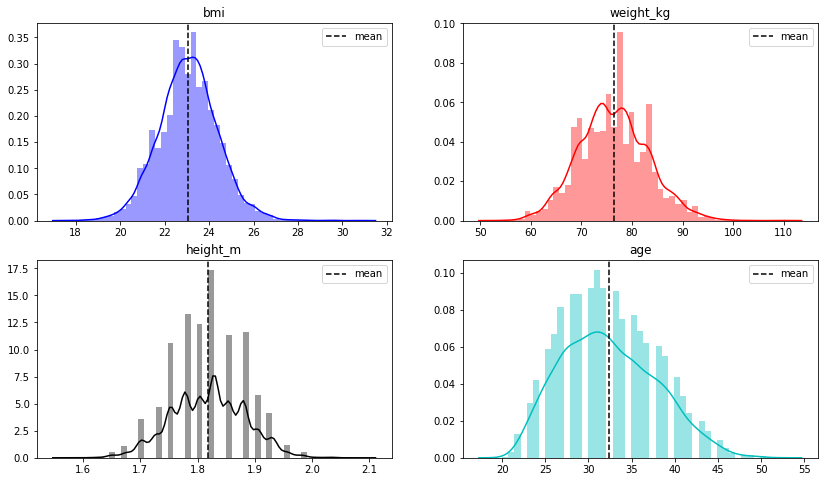

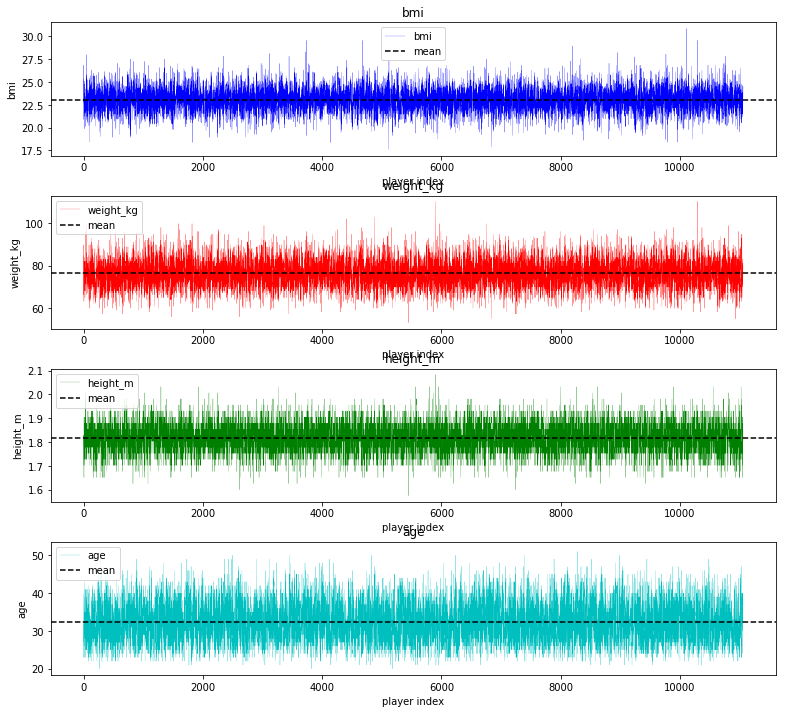

In [8]:
## Derive two auxiliary features, BMI & Age, 

DFs['dfPlayer']["weight_kg"] = DFs['dfPlayer']["weight"] * 0.453592
DFs['dfPlayer']["height_m"]  = DFs['dfPlayer']["height"] / 100

## Derive BMI:
DFs['dfPlayer']["bmi"]      = DFs['dfPlayer']["weight_kg"]/(DFs['dfPlayer']["height_m"] * DFs['dfPlayer']["height_m"])

## Derive Age from year in a player's birthday attribute:
DFs['dfPlayer']["year"]  = pd.DatetimeIndex(DFs['dfPlayer']["birthday"]).year
DFs['dfPlayer']["age"]   = ThisYear - DFs['dfPlayer']["year"]


### Normal Distribution of selected Player Attributes
cols  = ["bmi", "weight_kg", "height_m", "age"]
length = len(cols)
cplt01 = ["b","r","k","c"]  ## color palette
plt.figure(figsize=(14, 8))

for i, j, k in itertools.zip_longest(cols, range(length), cplt01): 
  plt.subplot(2,2,j+1)
  sns.distplot(DFs['dfPlayer'][i], color=k)    ## distribution plot()
  plt.axvline(DFs['dfPlayer'][i].mean(), color = "k", linestyle = "dashed", label="mean")
  plt.legend(loc="best")
  plt.title(i)
  plt.xlabel("")

## Horizontal lines diagrams on Weight, Height, BMI and Ages:
cplt02 = ["b","r","g","c"]

plt.figure(figsize=(13, 12))

for i, j, k in itertools.zip_longest(cols, range(length), cplt02):
  plt.subplot(4,1,j+1)
  DFs['dfPlayer'][i].plot(color = k, linewidth =.2, label = i)  ## plot()
  plt.axhline(DFs['dfPlayer'][i].mean(), color = "k", linestyle = "dashed", label="mean")
  plt.legend(loc="best")
  plt.subplots_adjust(hspace = .3)
  plt.xlabel("player index")
  plt.ylabel(i)
  plt.title(i)

### Players Min/Max:

In [9]:
print ("Min/Max of PLAYER ATTRIBUTES")
print ("=" * 80)

### Age: Oldest & Youngest players
dfOldestPlayers = DFs['dfPlayer'].loc[DFs['dfPlayer']["age"].idxmax()]
dfYoungestPlayers = DFs['dfPlayer'].loc[ DFs['dfPlayer']["age"].idxmin() ]

print("Oldest Player is {} of age {:3.0f} years old.".format( ", ".join(
  list( DFs['dfPlayer'][ DFs['dfPlayer']["age"] == dfOldestPlayers["age"] ]["player_name"])),
                                                             dfOldestPlayers["age"]))

print("Youngest Players are {} of age {:3.0f} years old.".format( ", ".join(
  list( DFs['dfPlayer'][DFs['dfPlayer']["age"] == dfYoungestPlayers["age"] ]["player_name"])),
                                                                 dfYoungestPlayers["age"] ))


### Height: Tallest & Shortest players
dfTallestPlayers = DFs['dfPlayer'].loc[ DFs['dfPlayer']["height_m"].idxmax()]
dfShortestPlayers = DFs['dfPlayer'].loc[ DFs['dfPlayer']["height_m"].idxmin() ]

print("Tallest Player is {} of Height {:2.2f} meters.".format( ", ".join( list( DFs['dfPlayer'][
  DFs['dfPlayer']["height_m"] == dfTallestPlayers["height_m"]]["player_name"])) , dfTallestPlayers["height_m"] ))

print("Shortest Player is {} of Height {:2.2f} meters.".format( ", ".join(
  list( DFs['dfPlayer'][ DFs['dfPlayer']["height_m"] == dfShortestPlayers["height_m"]]["player_name"])),
                                                               dfShortestPlayers["height_m"] ))


### Weight: Heaviest & Lightest players
dfHeaviestPlayers = DFs['dfPlayer'].loc[DFs['dfPlayer']["weight_kg"].idxmax()]
dfLightestPlayers = DFs['dfPlayer'].loc[DFs['dfPlayer']["weight_kg"].idxmin()]

print("Player with Highest weight is {} of Weight {:3.2f} kilograms".format( ", ".join(
  list( DFs['dfPlayer'][ DFs['dfPlayer']["weight_kg"] == dfHeaviestPlayers["weight_kg"] ]["player_name"])),
                                                                            dfHeaviestPlayers["weight_kg"]))

print("Player with Lowest weight is {} of Weight {:3.2f} kilograms".format( ", ".join(
  list( DFs['dfPlayer'][ DFs['dfPlayer']["weight_kg"] == dfLightestPlayers["weight_kg"] ]["player_name"])),
                                                                           dfLightestPlayers["weight_kg"] ))


### BMI: Max & min BMI players
dfMaxBMIPlayers = DFs['dfPlayer'].loc[DFs['dfPlayer']["bmi"].idxmax()]
dfMinBMIPlayers = DFs['dfPlayer'].loc[DFs['dfPlayer']["bmi"].idxmin()]

print("Player with Highest Body Mass Index is {} of {:3.2f} kg/m2".format( ", ".join(
  list( DFs['dfPlayer'][ DFs['dfPlayer']["bmi"] == dfMaxBMIPlayers["bmi"]]["player_name"])),
                                                                          dfMaxBMIPlayers["bmi"]  ))

print("Player with Lowest Body Mass Index is {} of {:3.2f} kg/m2".format( ", ".join(
  list( DFs['dfPlayer'][ DFs['dfPlayer']["bmi"] == dfMinBMIPlayers["bmi"]]["player_name"])),
                                                                         dfMinBMIPlayers["bmi"]))


Min/Max of PLAYER ATTRIBUTES
Oldest Player is Alberto Fontana of age  52 years old.
Youngest Players are Alban Lafont, Gianluigi Donnarumma, Jonathan Leko of age  20 years old.
Tallest Player is Kristof van Hout of Height 2.08 meters.
Shortest Player is Juan Quero of Height 1.57 meters.
Player with Highest weight is Kristof van Hout, Tim Wiese of Weight 110.22 kilograms
Player with Lowest weight is Juan Quero of Weight 53.07 kilograms
Player with Highest Body Mass Index is Sylvan Ebanks-Blake of 30.87 kg/m2
Player with Lowest Body Mass Index is John Stewart of 17.59 kg/m2


### Heatmap - Statistics on 4 Selected Player Attributes 

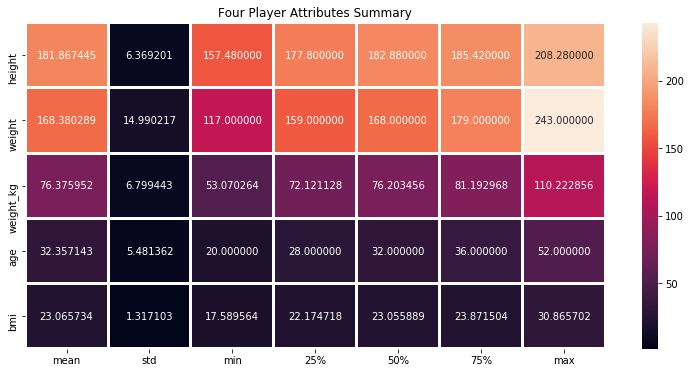

In [10]:
## Pandas describe() reports the Statistics profile of a sample dataset including Mean, Standard Deviation, Min/Max,
## 25%, 50% and 75%. I collected a handful of player physical attributes and used Seaborn Heatmap to get an idea
## at high level.

plt.figure(figsize=(13,6))

sns.heatmap(DFs['dfPlayer'][["height", "weight", "weight_kg", "age", "bmi"]].describe()[1:].transpose(),
            annot=True, fmt="f", linecolor="white", linewidths=2)

plt.title("Four Player Attributes Summary")
plt.show()

### Heatmap - Correlation Among Numerical Attributes in Player DataFrame

Correlation coefficient of two variables in a data sample is a normalized measurement of how they are linearly related. It provides a clue to tell how strong two variables are related provided the data sample is normal distribution.

Seaborn heatmap offers an intuitive way to reveal the correlation among features pairwise.   

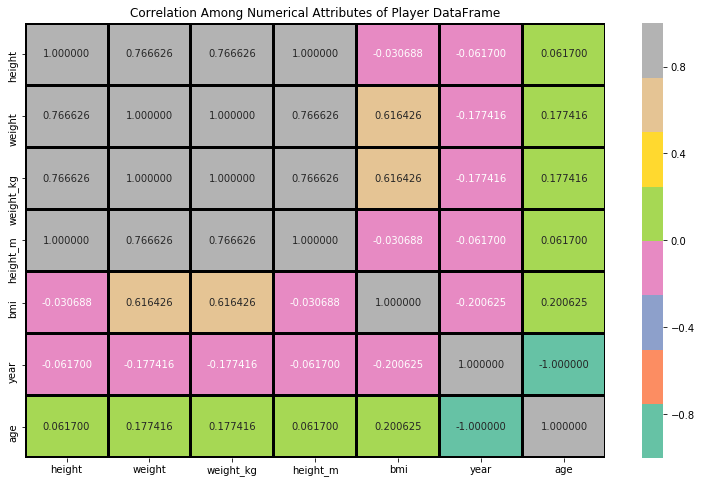

In [11]:
## Correlation HeadMap:

dfPlayerNumAttrs = getNumAttrs(DFs['dfPlayer'])
corrPlayerNumAttrs = dfPlayerNumAttrs.loc[:, dfPlayerNumAttrs.columns[3:]].corr()

plt.figure(figsize=(13,8))
sns.heatmap(corrPlayerNumAttrs, annot=True, fmt="f", linecolor="k", linewidths=2, cmap = sns.color_palette("Set2"))

plt.title("Correlation Among Numerical Attributes of Player DataFrame")
plt.show()

### Scatter PairPlot Matrix - Correction Among Numerical Attributes in Players:

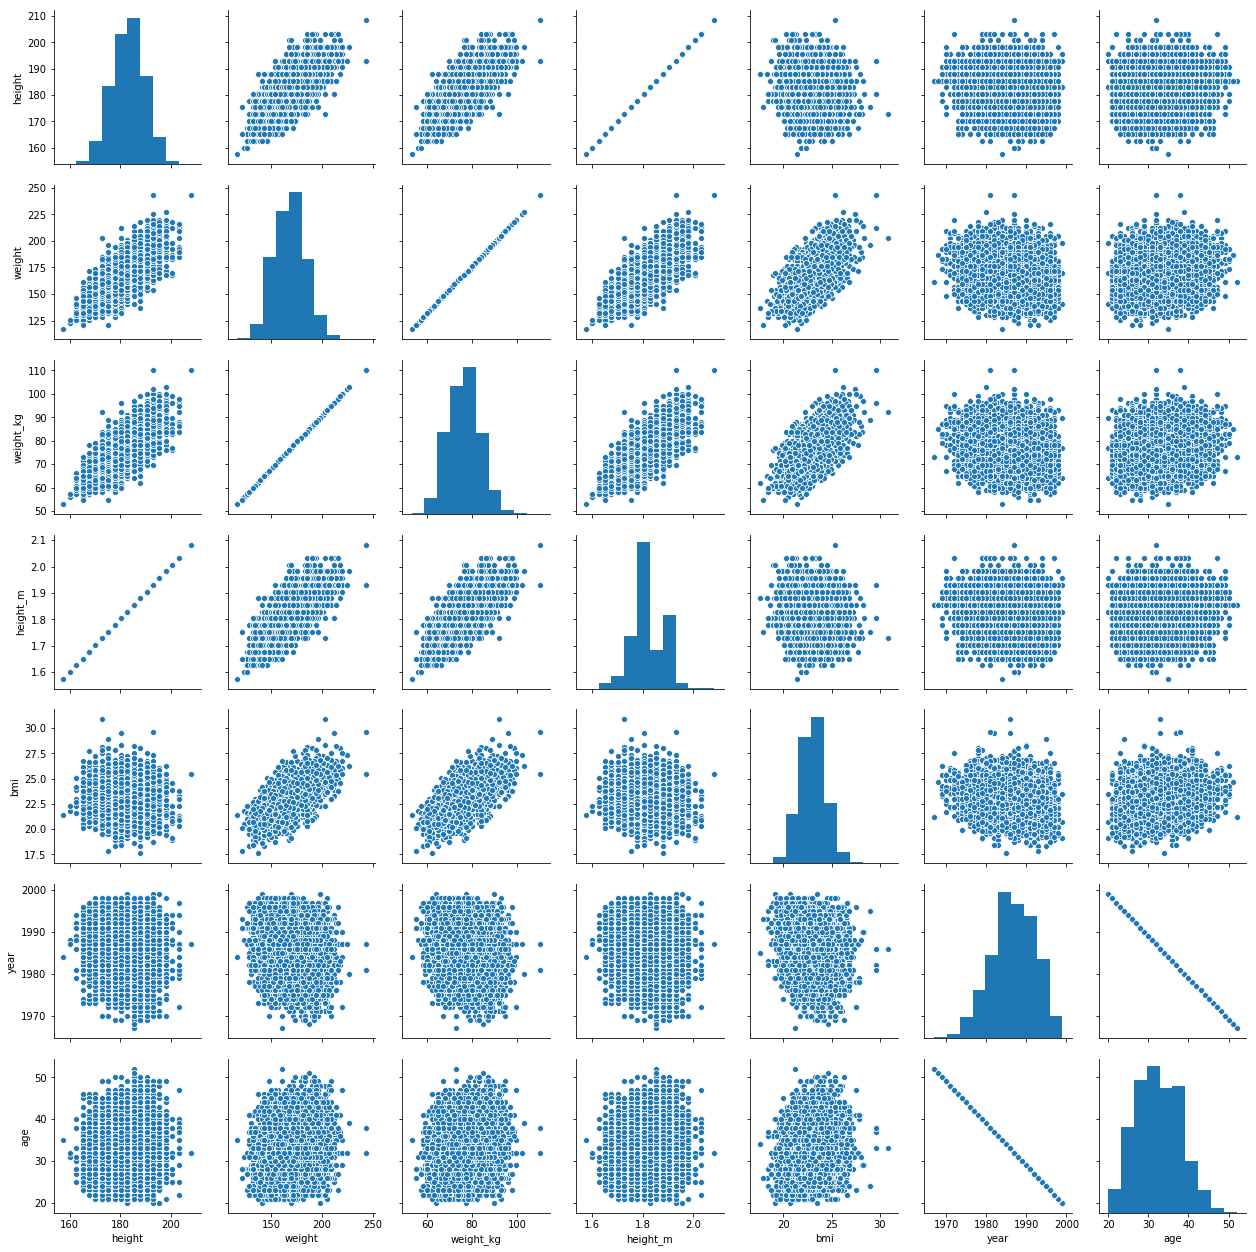

In [12]:
sns.pairplot( dfPlayerNumAttrs.loc[:, dfPlayerNumAttrs.columns[3:]] );

### Scatter Plots on Age vs Weight, Height and BMI
The Scatterplot Matrix above showed potential correlation among Weight, Height and BMI. I'd like to look in further whether Age may have any correlation with any of these. I used Scatter plot to find out the correlation. 

No apparent correclation was found.

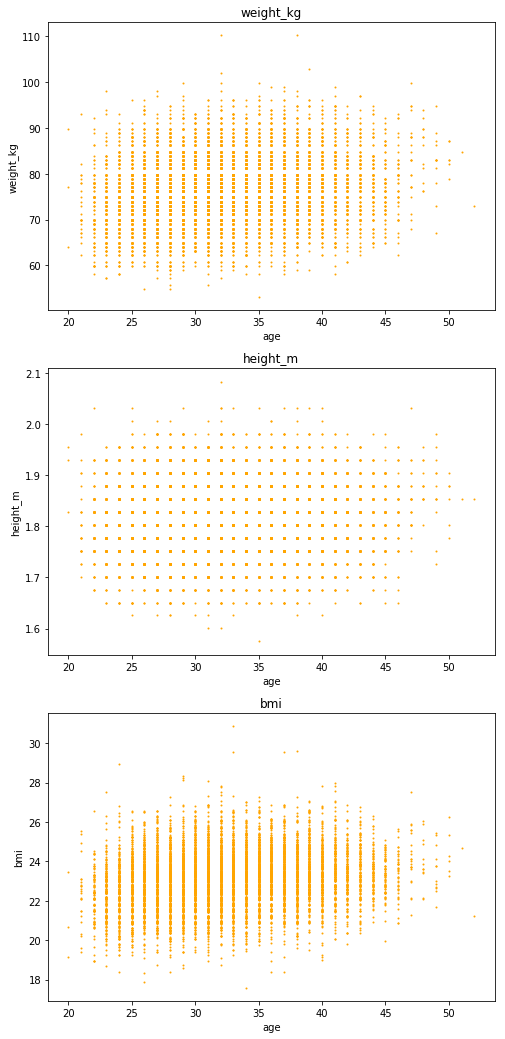

In [13]:
### Scatter Plot for Age vs Weight, Height and BMI
cols = [ 'weight_kg', 'height_m', 'bmi']
length=len(cols)
plt.figure(figsize=(8,18))

for i, j in itertools.zip_longest(cols, range(length)):
  plt.subplot(3, 1, j+1)
  plt.scatter(DFs['dfPlayer']["age"], DFs['dfPlayer'][i], color="Orange", s= 1)

  plt.xlabel("age")
  plt.ylabel(i)
  plt.title(i)

### Bar Chart to view Counts on the Initials of Players' First and Last Names:

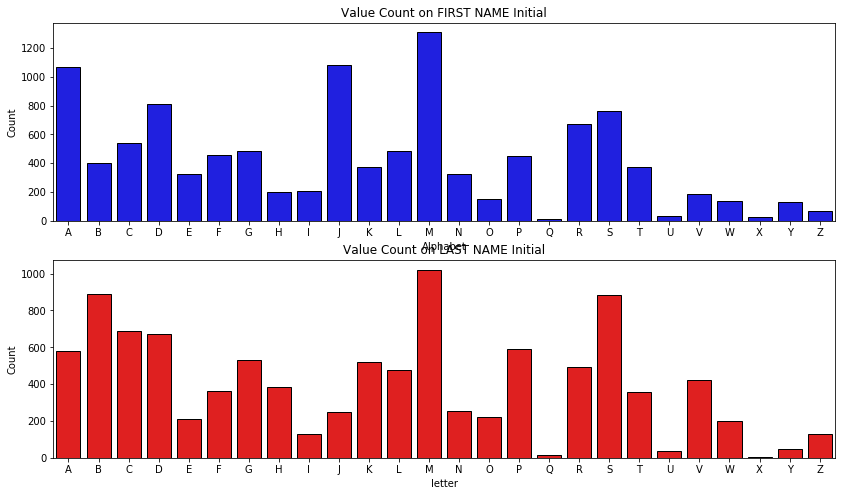

In [14]:
### Counts on Player Name Initials:
firstIniCount = pd.DataFrame(DFs['dfPlayer']["player_name"].str.split(" ").str[0].str.upper().str[:1].value_counts())
lastIniCount = pd.DataFrame(DFs['dfPlayer']["player_name"].str.split(" ").str[1].str.upper().str[:1].value_counts())
Inis = firstIniCount.merge(lastIniCount, left_index=True, right_index=True, how="left").reset_index()
Inis = Inis.rename(columns={"index":"letter", "player_name_x":'first_name', "player_name_y":"last_name"}).sort_values(
  by="letter", ascending = True)

plt.figure(figsize=(14, 8))

plt.subplot(211)
sns.barplot(Inis["letter"], Inis["first_name"], color="b", linewidth = 1, edgecolor = "k"*26)
plt.ylabel("Count")
plt.xlabel("Alphabet")
plt.title("Value Count on FIRST NAME Initial")

plt.subplot(212)
sns.barplot(Inis["letter"], Inis["last_name"], color="r", linewidth = 1, edgecolor = "k"*26)
plt.ylabel("Count")
plt.title("Value Count on LAST NAME Initial")
plt.show()

>## <a id='analyzing_playerattributes'></a> Analyzing Player Attributes Table

###  Extract Numerical Attributes to a New DataFrame

In [15]:
dfNumPlayerAttrs = getNumAttrs(DFs['dfPlayer_Attributes'])
dfNumPlayerAttrs.head().loc[:, dfNumPlayerAttrs.columns[3:]].head()

overall_rating  potential  crossing  finishing  heading_accuracy  \
0            67.0       71.0      49.0       44.0              71.0   
1            67.0       71.0      49.0       44.0              71.0   
2            62.0       66.0      49.0       44.0              71.0   
3            61.0       65.0      48.0       43.0              70.0   
4            61.0       65.0      48.0       43.0              70.0   

   short_passing  volleys  dribbling  curve  free_kick_accuracy  long_passing  \
0           61.0     44.0       51.0   45.0                39.0          64.0   
1           61.0     44.0       51.0   45.0                39.0          64.0   
2           61.0     44.0       51.0   45.0                39.0          64.0   
3           60.0     43.0       50.0   44.0                38.0          63.0   
4           60.0     43.0       50.0   44.0                38.0          63.0   

   ball_control  acceleration  sprint_speed  agility  reactions  balance  \
0          49.0          60.0          64.0     59.0       47.0     65.0   
1          49.0          60.0          64.0     59.0       47.0     65.0   
2          49.0          60.0          64.0     59.0       47.0     65.0   
3          48.0          60.0          64.0     59.0       46.0     65.0   
4          48.0          60.0          64.0     59.0       46.0     65.0   

   shot_power  jumping  stamina  strength  long_shots  aggression  \
0        55.0     58.0     54.0      76.0        35.0        71.0   
1        55.0     58.0     54.0      76.0        35.0        71.0   
2        55.0     58.0     54.0      76.0        35.0        63.0   
3        54.0     58.0     54.0      76.0        34.0        62.0   
4        54.0     58.0     54.0      76.0        34.0        62.0   

   interceptions  positioning  vision  penalties  marking  standing_tackle  \
0           70.0         45.0    54.0       48.0     65.0             69.0   
1           70.0         45.0    54.0       48.0     65.0             69.0   
2           41.0         45.0    54.0       48.0     65.0             66.0   
3           40.0         44.0    53.0       47.0     62.0             63.0   
4           40.0         44.0    53.0       47.0     62.0             63.0   

   sliding_tackle  gk_diving  gk_handling  gk_kicking  gk_positioning  \
0            69.0        6.0         11.0        10.0             8.0   
1            69.0        6.0         11.0        10.0             8.0   
2            69.0        6.0         11.0        10.0             8.0   
3            66.0        5.0         10.0         9.0             7.0   
4            66.0        5.0         10.0         9.0             7.0   

   gk_reflexes  
0          8.0  
1          8.0  
2          8.0  
3          7.0  
4          7.0

### HeatMap -  Correlation among Numerical features.

We should see a positive correlation between the attacking features, a positive correlation between the defensive features and a negative correlation between the attacking and defensive features.

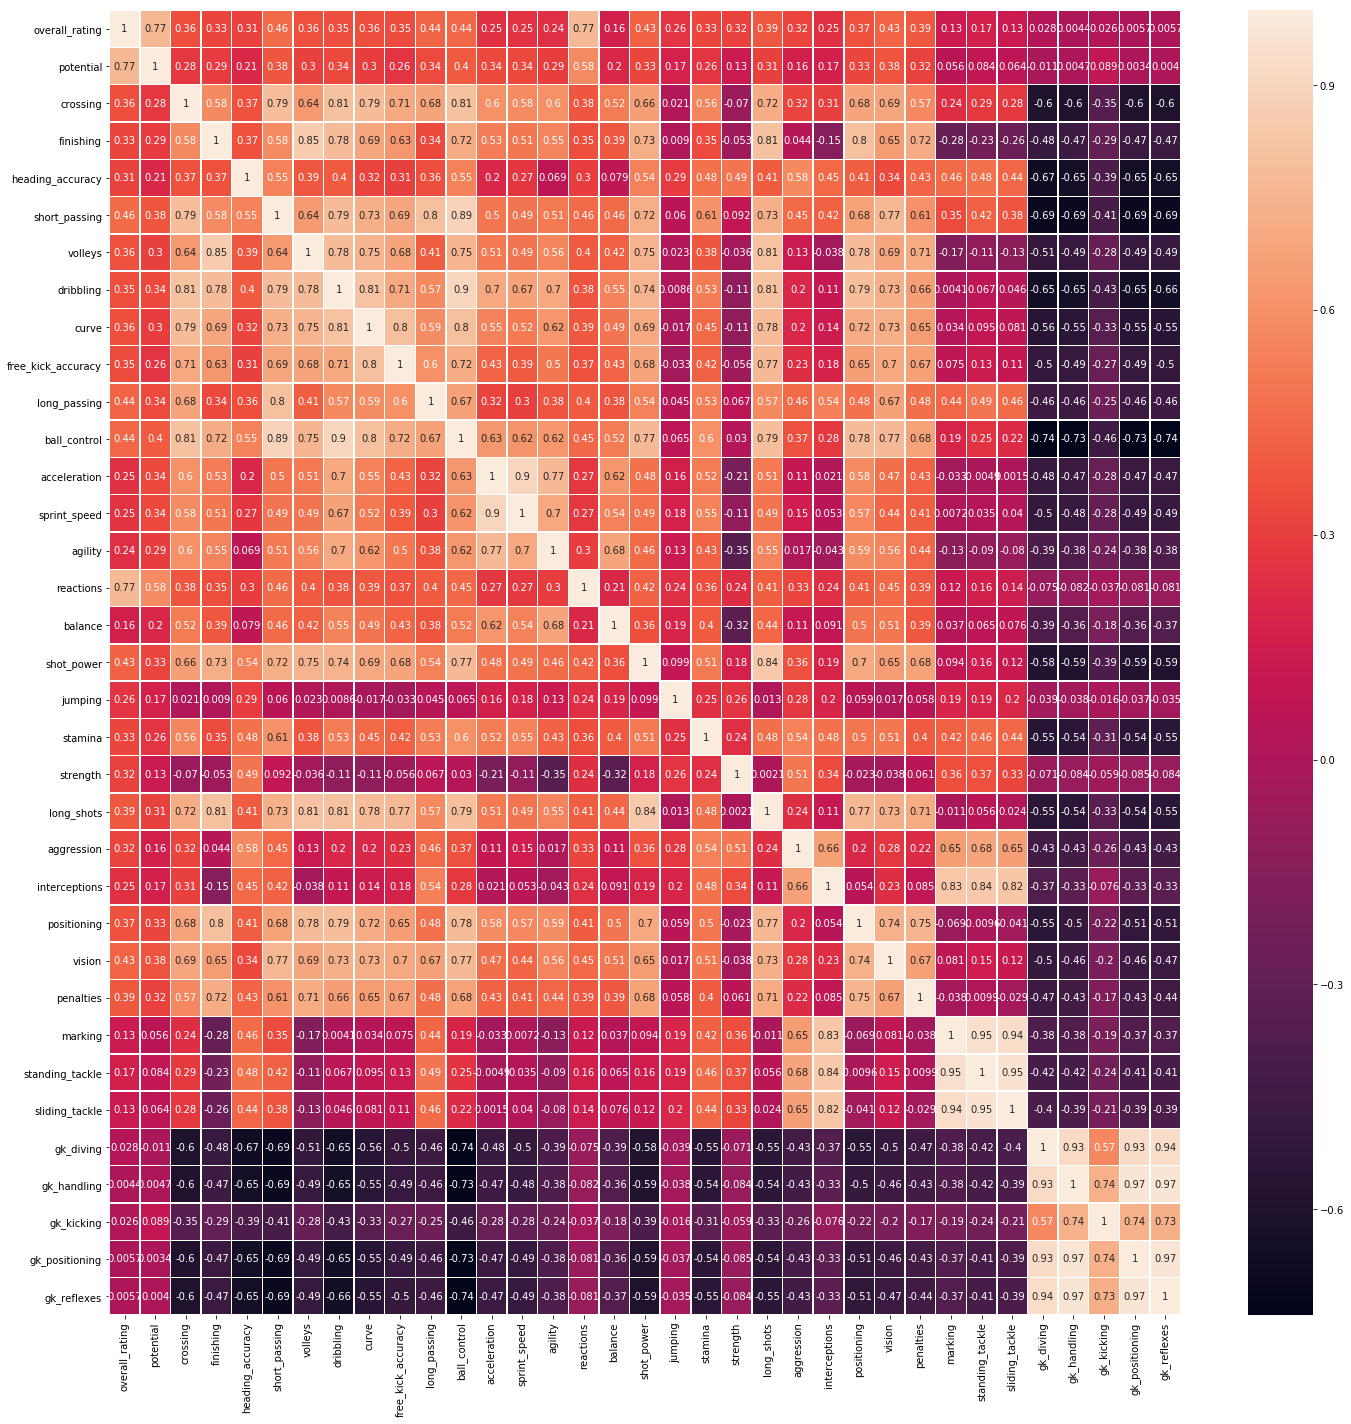

In [16]:
## Correlation matrix of Numerical fields on Player Attributes, excluding the First 3 ID columns:
corr2 = dfNumPlayerAttrs.loc[:, dfNumPlayerAttrs.columns[3:]].corr()

fig2,ax2 = plt.subplots(nrows = 1,ncols = 1)
fig2.set_size_inches(w=24, h=24)

sns.heatmap(corr2,annot = True, linewidths=0.5, ax = ax2);

### Extract Categorical Attributes to a New DataFrame

* A home-made function, getCatAttrs(), extracts categorical attributes in Player Attributes to a new dataframe.
* Cardinality is a measure of uniqueness and is often applied on categorical attributes to determine whether any of them can be
* All four cardinalities, 0.107%, 0.002%, 0.004% and 0.011%, are very small which represent these attributes have very limited distinct values. Their values share a lot in common.   

In [17]:
## Find Cardinality among categorical features in Player Attributes dataframe:

## Retrieve Categorical Attributes from Player Attributes to a new DataFrame:
dfCatPlayerAttrs = getCatAttrs(DFs['dfPlayer_Attributes'])

## Show Cardinality of categotical attributes on Player Attributes dataframe:
for catattr in getColNames(dfCatPlayerAttrs):

  cardi = 100 * ( 
    len(np.unique( dfCatPlayerAttrs.loc[:, catattr].astype(str)))) / len(dfCatPlayerAttrs.loc[:, catattr].astype(str))
  
  print("Cardinality of {} - {:0.3f}%".format(catattr, cardi))

Cardinality of date - 0.107%
Cardinality of preferred_foot - 0.002%
Cardinality of attacking_work_rate - 0.004%
Cardinality of defensive_work_rate - 0.011%


### Count Plots on Preferred_Foot, Attacking_Work_Rate, and Defensive_Work_Rate

Use *Count plots* to get an idea about three Categorical attributes, preferred_foot, attacking_work_rate, and defensive_work_rate. The intention is to figure out:
 - which columns might have abnormal attacking and defensive work rate.
 - Is there a correlation between attacking and defensive work rate values? If abnormal, how so?
 
The charts were followed by their corresponding statistics to streamline the comparison. 

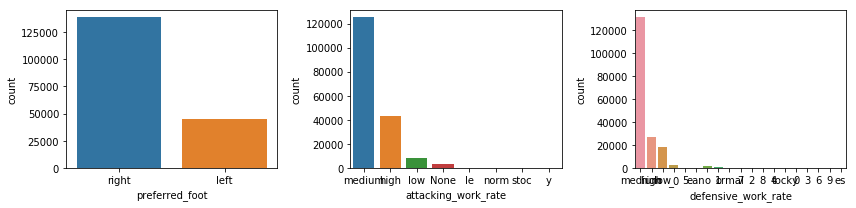

In [18]:
fig3, ax3 = plt.subplots(nrows = 1, ncols = 3)
fig3.set_size_inches(12, 3)

sns.countplot(x = DFs['dfPlayer_Attributes']['preferred_foot'], ax = ax3[0])
sns.countplot(x = DFs['dfPlayer_Attributes']['attacking_work_rate'], ax = ax3[1])
sns.countplot(x = DFs['dfPlayer_Attributes']['defensive_work_rate'], ax = ax3[2])

fig3.tight_layout()

In [19]:
print("Player Attrs Dimension {} - Records: {} & Attributes: {}\n".format(DFs['dfPlayer_Attributes'].shape,
                                                                          DFs['dfPlayer_Attributes'].shape[0],
                                                                          DFs['dfPlayer_Attributes'].shape[1]))

print("Attacking Work Rate:\n{}".format(DFs['dfPlayer_Attributes']['attacking_work_rate'].value_counts()))
print(80*'*')

print("Defensive Work Rate:\n{}".format(DFs['dfPlayer_Attributes']['defensive_work_rate'].value_counts()))
print(80*'*')

Player Attrs Dimension (183978, 42) - Records: 183978 & Attributes: 42

Attacking Work Rate:
medium    125070
high       42823
low         8569
None        3639
norm         348
y            106
le           104
stoc          89
Name: attacking_work_rate, dtype: int64
********************************************************************************
Defensive Work Rate:
medium    130846
high       27041
low        18432
_0          2394
o           1550
1            441
ormal        348
2            342
3            258
5            234
7            217
0            197
6            197
9            152
4            116
es           106
ean          104
tocky         89
8             78
Name: defensive_work_rate, dtype: int64
********************************************************************************


### Attacking vs Defensive Work Rate
- Work rates are how hard players works on each end of the field.
- The levels of attacking and defensive work rate should be *Low*, *Medium*, and *Hhigh*. They account for the majority of instances.
- The rest of levels can be filtered out.

Based on the count plots we can confirm filtering out the rest of levels has little impact on our analyses.  

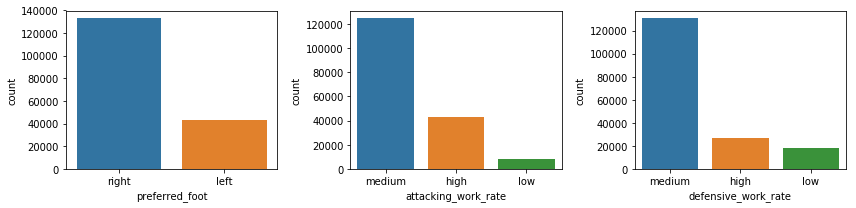

In [20]:
### Filter Work_Rates based on Low, Medium and High.
DFs['dfPlayer_Attributes_3WorkRates'] = DFs['dfPlayer_Attributes'].loc[
  (DFs['dfPlayer_Attributes']['attacking_work_rate'].isin(['medium','high','low']) & \
   DFs['dfPlayer_Attributes']['defensive_work_rate'].isin(['medium','high','low'])), :]

## After filtering out values we inspect three diagrams again:
fig4, ax4 = plt.subplots(nrows = 1, ncols = 3)
fig4.set_size_inches(12,3)

sns.countplot(x = DFs['dfPlayer_Attributes_3WorkRates']['preferred_foot'], ax = ax4[0])
sns.countplot(x = DFs['dfPlayer_Attributes_3WorkRates']['attacking_work_rate'], ax = ax4[1])
sns.countplot(x = DFs['dfPlayer_Attributes_3WorkRates']['defensive_work_rate'], ax = ax4[2])
fig4.tight_layout()

### Count Plots on Preferred_Foot, Attacking_Work_Rate, and Defensive_Work_Rate

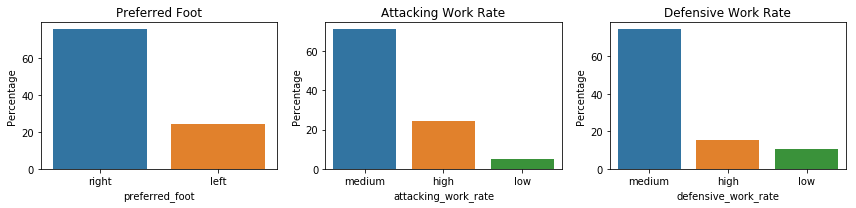

In [21]:
fig4, ax4 = plt.subplots(nrows = 1, ncols = 3)
fig4.set_size_inches(12,3)

sns.barplot(x ='preferred_foot', y = 'preferred_foot', data = DFs['dfPlayer_Attributes_3WorkRates'],\
            estimator = lambda x: len(x)/len(DFs['dfPlayer_Attributes_3WorkRates']) * 100, ax = ax4[0], orient = 'v')

ax4[0].set(ylabel = 'Percentage',title = 'Preferred Foot')
sns.barplot(x ='attacking_work_rate', y = 'attacking_work_rate', data = DFs['dfPlayer_Attributes_3WorkRates'],\
            estimator = lambda x: len(x)/len(DFs['dfPlayer_Attributes_3WorkRates']) * 100, ax = ax4[1], orient = 'v')

ax4[1].set(ylabel = 'Percentage',title = 'Attacking Work Rate')
sns.barplot(x ='defensive_work_rate', y = 'defensive_work_rate', data = DFs['dfPlayer_Attributes_3WorkRates'],\
            estimator = lambda x: len(x)/len(DFs['dfPlayer_Attributes_3WorkRates']) * 100, ax = ax4[2], orient = 'v')

ax4[2].set(ylabel = 'Percentage', title = 'Defensive Work Rate')

fig4.tight_layout()

In [22]:
att_work_rate = DFs['dfPlayer_Attributes_3WorkRates'].groupby('attacking_work_rate').size().values.tolist()
def_work_rate = DFs['dfPlayer_Attributes_3WorkRates'].groupby('defensive_work_rate').size().values.tolist()

print("Attacking work rate factor, Medium, accounts for: {:0.3f}% of features".format(
  100 * att_work_rate[2]/np.sum(att_work_rate)))

print("Defensive work rate factor, Medium, accounts for: {:0.3f}% of features".format(
  100 * def_work_rate[2]/np.sum(def_work_rate)))

Attacking work rate factor, Medium, accounts for: 70.885% of features
Defensive work rate factor, Medium, accounts for: 74.230% of features


### Percentage of rows eliminated due to invalid/strange attacking and defensive work rate values:

In [23]:
print("Percentage of instances removed from player attributes table: {:0.2f}%".format(
  100* (1 - DFs['dfPlayer_Attributes_3WorkRates'].shape[0] / DFs['dfPlayer_Attributes'].shape[0])))

print("We removed {} instances from Player Attributes table".format(
  -DFs['dfPlayer_Attributes_3WorkRates'].shape[0] + DFs['dfPlayer_Attributes'].shape[0]))

Percentage of instances removed from player attributes table: 4.25%
We removed 7817 instances from Player Attributes table


### Use Distribution plots to compare numerical features in Player Attributes against preferred_foot
Analyze distribution and spead of continuous features based off of categorical features. Do the levels of each categorical features drastically change the distribution / spead of the continuous features?

Preferred Foot does not distinguish any of the variables in boxplots. 

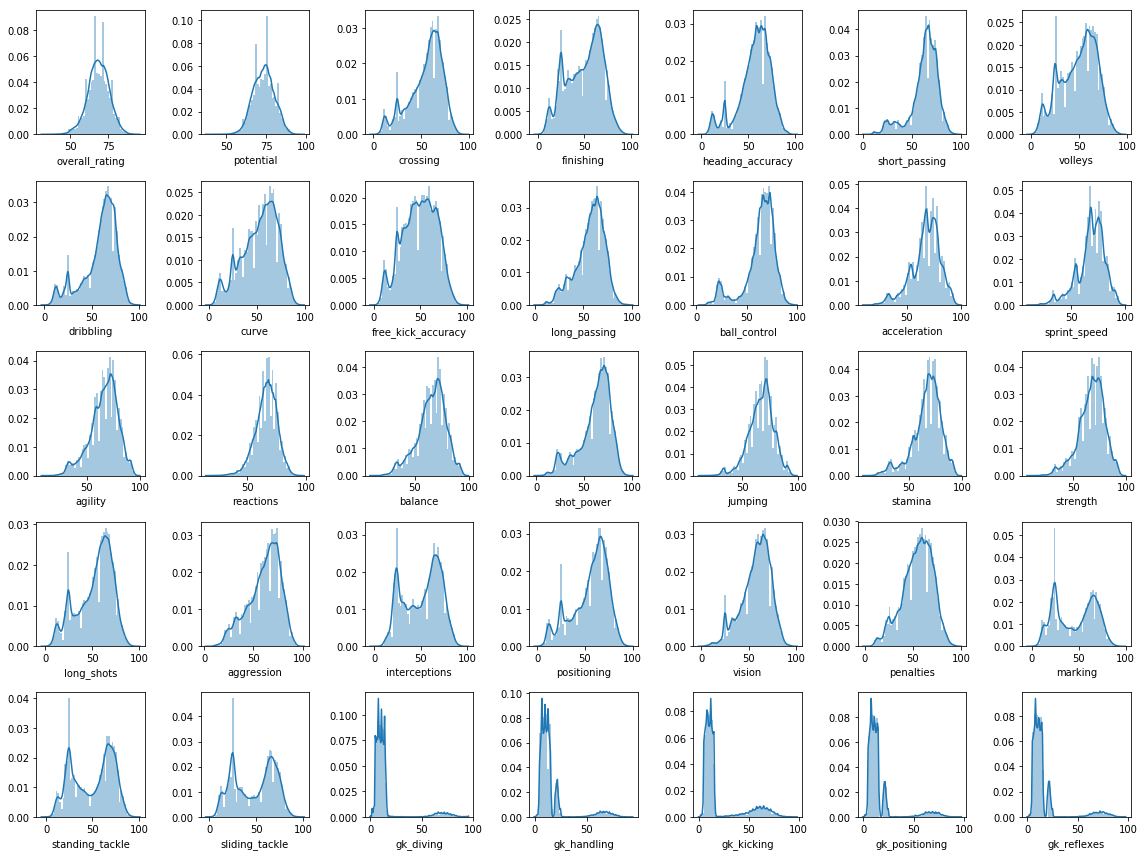

In [24]:
pat = DFs['dfPlayer_Attributes_3WorkRates'].loc[:, DFs['dfPlayer_Attributes_3WorkRates'].columns.tolist()[3:]]

fig5, ax5 = plt.subplots(nrows=5,ncols=7)
fig5.set_size_inches(16,12)

for i, j in enumerate(
  DFs['dfPlayer_Attributes_3WorkRates'].select_dtypes(include = ['float64','int64']).columns[3:].tolist()):
    
  sns.distplot(pat.loc[:,j], kde = True, hist = True, ax = ax5[int(i/7)][i%7])

fig5.tight_layout()


### Use boxplots to compare numerical features in Player Attributes against preferred_foot
Preferred Foot does not distinguish any of the variables in boxplots. 

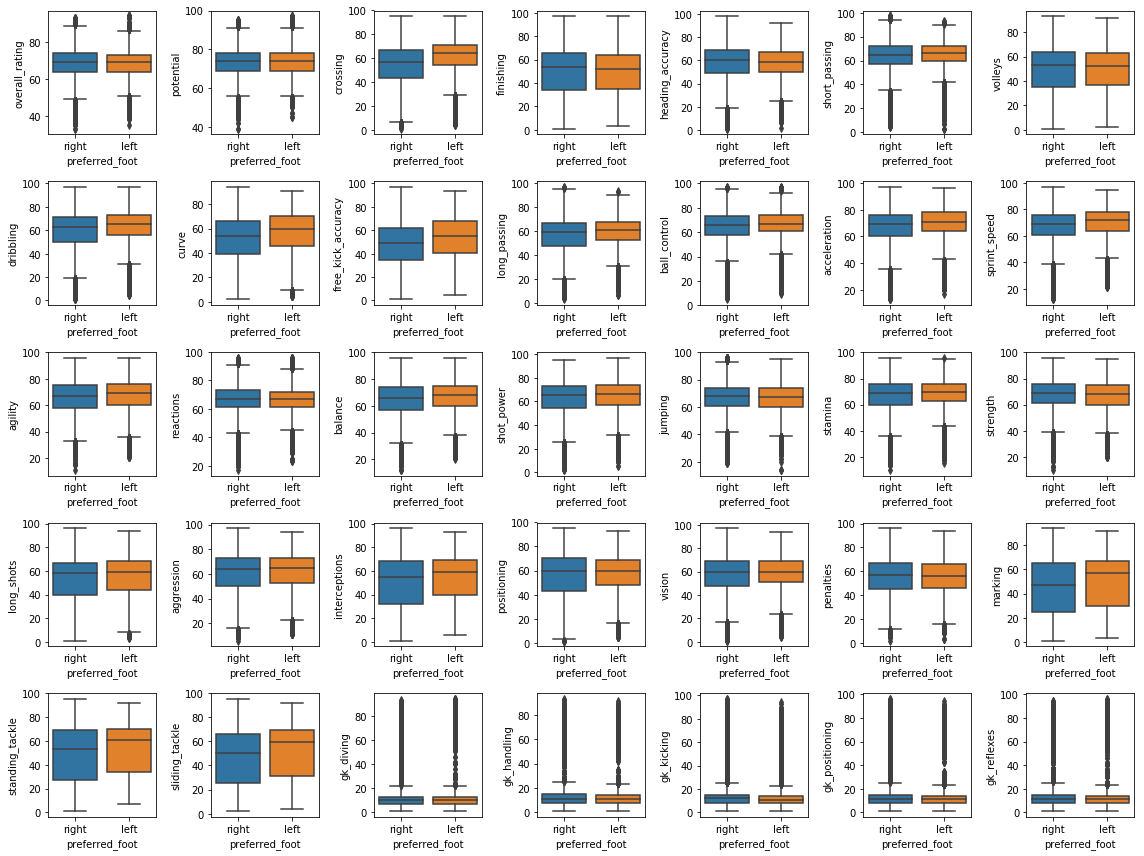

In [25]:
fig6, ax6 = plt.subplots(nrows=5, ncols=7)
fig6.set_size_inches(16,12)

for i,j in enumerate(
  DFs['dfPlayer_Attributes_3WorkRates'].select_dtypes(include = ['float64','int64']).columns[3:].tolist()):
  
  sns.boxplot(x = "preferred_foot", y = j, data= pat, ax = ax6[int(i/7)][i%7])
  
fig6.tight_layout()

### Distribution of features the same regardless of preferred foot

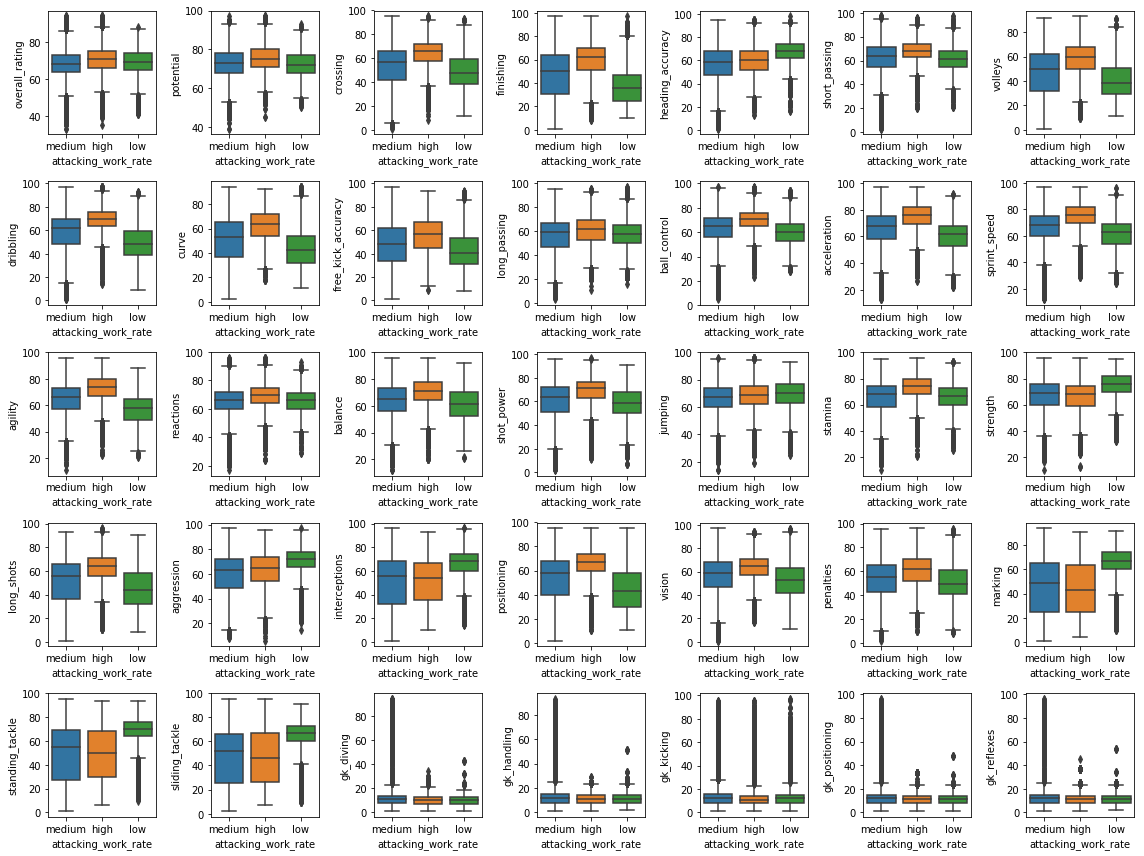

In [26]:
fig7, ax7 = plt.subplots(nrows=5,ncols=7)
fig7.set_size_inches(16,12)
for i,j in enumerate(
  DFs['dfPlayer_Attributes_3WorkRates'].select_dtypes(include = ['float64','int64']).columns[3:].tolist()):
  
  sns.boxplot(x = "attacking_work_rate", y = j, data= pat, ax = ax7[int(i/7)][i%7])

fig7.tight_layout() 

Compared with "preferred foot", "attacking work rate" is a better criteria to separate the features to some extent at either high or low attacking work rate. Yet, be aware that the Medium attacking work rate takes up to 70% of the instances. For features related to atacking attributes, attacking work rate feature does a good job of distinguishing instances of high and low categorical values.

Similar to attacking work rate, "defensive work rate" is a decent criteria to differentiate defensive attributes than "preferred foot" at high and low defensive work rate values.

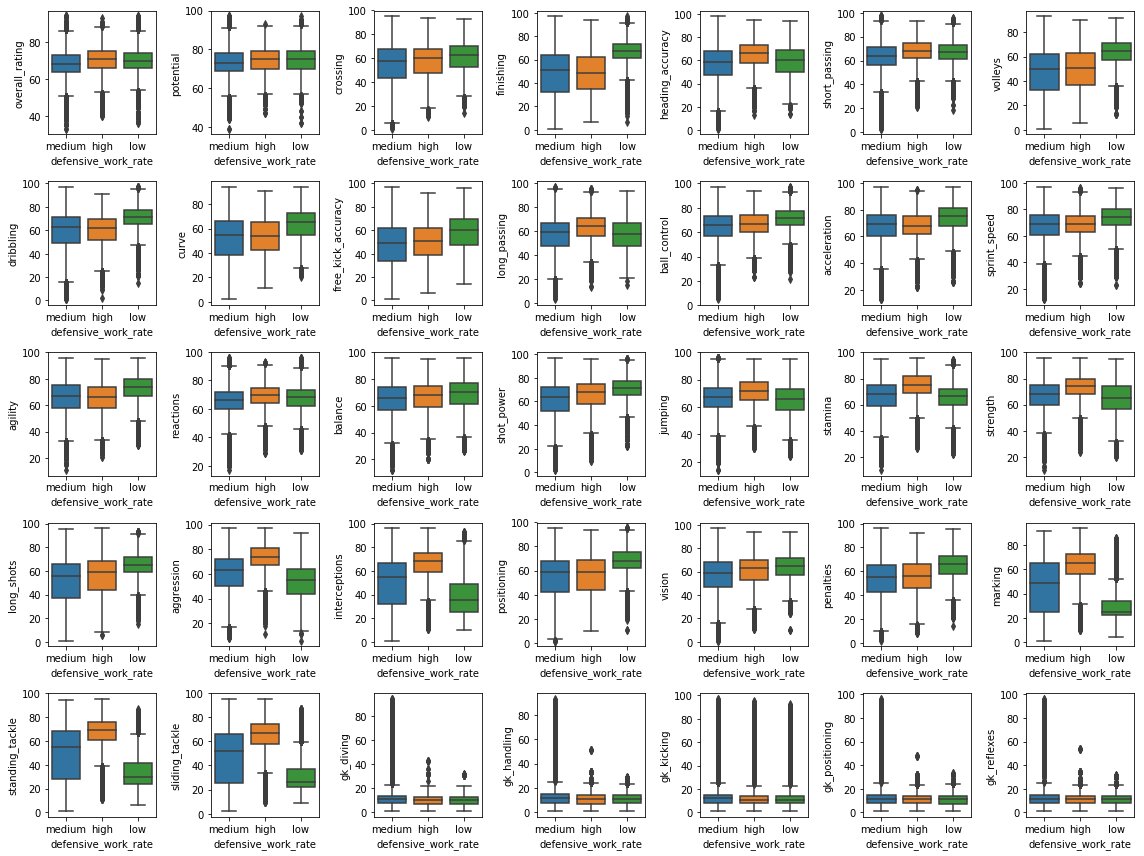

In [27]:
## View Relationships between Defensive Work Rate and all other Numerical Attributes on Updated Player Attributes DataFrame:

fig8, ax8 = plt.subplots(nrows=5,ncols=7)
fig8.set_size_inches(16,12)

for i,j in enumerate(
  DFs['dfPlayer_Attributes_3WorkRates'].select_dtypes(include = ['float64','int64']).columns[3:].tolist()):
  
  sns.boxplot(x = "defensive_work_rate", y = j, data= pat, ax = ax8[int(i/7)][i%7])

fig8.tight_layout()

>## <a id='analyze-team-table'></a> Analyzing Team Table 

In [28]:
## Filter out entries with empty team_fifa_api_id in Team DataFrame:
DFs['dfTeam_Updated'] = DFs['dfTeam'][ ~DFs['dfTeam'].loc[:,'team_fifa_api_id'].isna()]

## Analyzing the updated Team dataframe:
viewDF(DFs['dfTeam_Updated'], *attrs)

print("\nDescribe Categorical Attributes: {}".format(descCatAttrs(DFs['dfTeam_Updated'])))
print("\n{} Attributes with Missing Values: {}".format(tbl, showAttrsWMissingValues(DFs['dfTeam_Updated'])))
print("\n{} Members with Missing Values: {}".format(tbl, showEntitiesWMissingValues(DFs['dfTeam_Updated'])))


print("Cat Attributes Uniqueness: {}".format(
  DFs['dfTeam_Updated'].select_dtypes(exclude=['float64','int64']).apply(lambda x: len(x.unique().tolist()), axis=0)))

print("Team Long Name Uniqueness: {};\tTeam Long Name Uniqueness: {}".format(
  len(DFs['dfTeam_Updated']['team_long_name'].unique().tolist()),
  len(DFs['dfTeam_Updated']['team_short_name'].unique().tolist())))

 DataFrame shape: (288, 5)
 DataFrame columns: ['id', 'team_api_id', 'team_fifa_api_id', 'team_long_name', 'team_short_name']

info():
<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 0 to 297
Data columns (total 5 columns):
id                  288 non-null int64
team_api_id         288 non-null int64
team_fifa_api_id    288 non-null float64
team_long_name      288 non-null object
team_short_name     288 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 13.5+ KB

describe():                  id    team_api_id  team_fifa_api_id
count    288.000000     288.000000        288.000000
mean   23481.666667   11317.354167      21534.305556
std    15102.715862   22228.138190      42456.439408
min        1.000000    1601.000000          1.000000
25%     9551.750000    8370.750000        178.750000
50%    21288.500000    8658.500000        673.500000
75%    35770.250000    9885.750000       1910.750000
max    50204.000000  274581.000000     112513.000000

Describe

>## <a id='analyze-team-att-table'></a> Analyzing Team Attributes Table

In Team Attributes dataframe, "buildUpPlayDribbling" is the only field with  missing values. It doesn't seem to be related to the other featues and more than 50% of the features are missing. To avoid to skew data, drop the "buildUpPlayDribbling" feaure from dataset and continue analyzing the rest.

Perform the following tasks:
- Use describe() to view categorical attributes on the updated Team Attributes dataframe.
- Show attributes with missing values in the updated dataframe.
- Show any members with missing fields
- Check Uniqueness on dataframe

In [29]:
## Drop out buildUpPlayDribbling attribute 
DFs['dfTeam_Attributes_Updated'] = DFs['dfTeam_Attributes'].drop(['buildUpPlayDribbling'], axis = 1)

## Describe Categorical Attributes
print("\nDescribe Categorical attributes: {}".format(descCatAttrs(DFs['dfTeam_Attributes_Updated'])))

print("\n{} Attributes with Missing Values: {}".format(
  tbl, showAttrsWMissingValues(DFs['dfTeam_Attributes_Updated'])))

print("\n{} Members with Missing Values: {}".format(
  tbl, showEntitiesWMissingValues(DFs['dfTeam_Attributes_Updated'])))

## Uniqueness
print("\nUnique Values in Categorical Attributes: {}".format(
  DFs['dfTeam_Attributes_Updated'].select_dtypes(exclude=['float64','int64']).apply(
    lambda x: len(x.unique().tolist()), axis = 0)))


Describe Categorical attributes:                        date buildUpPlaySpeedClass buildUpPlayDribblingClass  \
count                  1458                  1458                      1458   
unique                    6                     3                         3   
top     2015-09-10 00:00:00              Balanced                    Little   
freq                    245                  1184                      1004   

       buildUpPlayPassingClass buildUpPlayPositioningClass  \
count                     1458                        1458   
unique                       3                           2   
top                      Mixed                   Organised   
freq                      1236                        1386   

       chanceCreationPassingClass chanceCreationCrossingClass  \
count                        1458                        1458   
unique                          3                           3   
top                        Normal                      Normal   

### View Distribution on Numerical Team Attributes

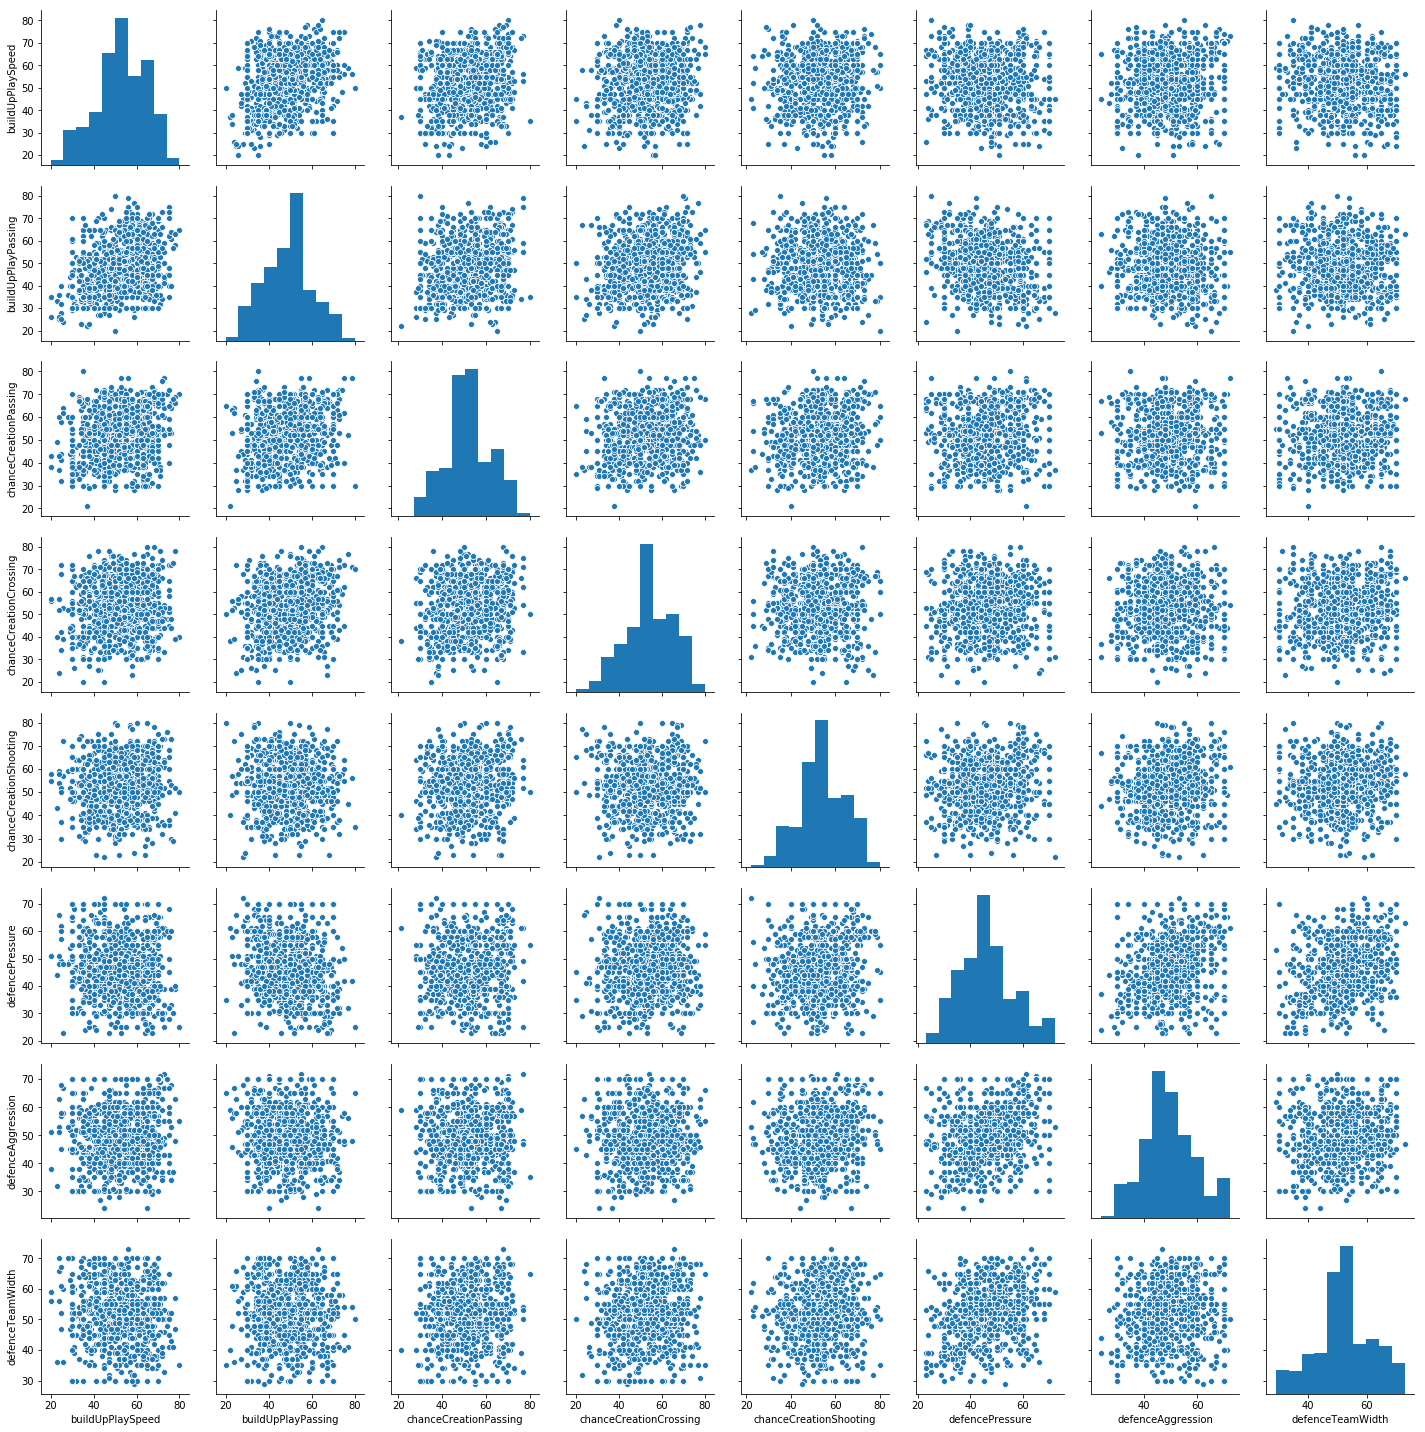

In [30]:
tat = DFs['dfTeam_Attributes_Updated'].loc[:, DFs['dfTeam_Attributes_Updated'].columns.tolist()[3:]]

sns.pairplot(tat);

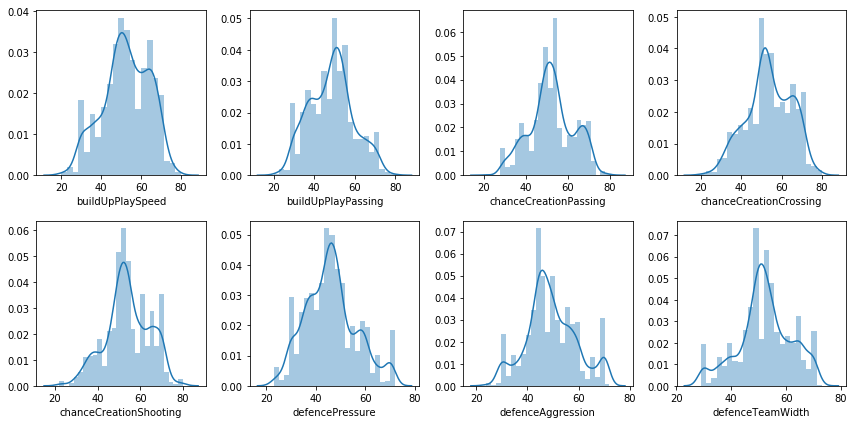

In [31]:
fig9, ax9 = plt.subplots(nrows=2,ncols=4)
fig9.set_size_inches(12,6)
for i,j in enumerate(DFs['dfTeam_Attributes_Updated'].select_dtypes(include = ['int64']).columns[3:].tolist()):
    sns.distplot(tat.loc[:,j],kde =True,hist = True, ax = ax9[int(i/4)][i%4])
fig9.tight_layout()

### View Boxplot on Numerical Team Attributes

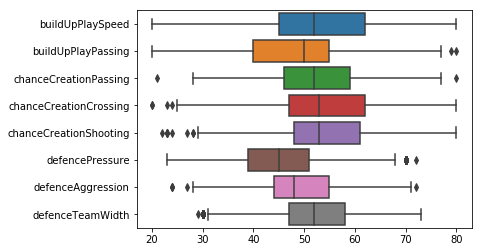

In [32]:
sns.boxplot(data = DFs['dfTeam_Attributes_Updated'].select_dtypes(include = ['int64']).iloc[:,3:], orient = 'h');

### View Bar Plots on Categorical Team Attributes

['buildUpPlaySpeed', 'buildUpPlayPassing', 'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 'defencePressure', 'defenceAggression', 'defenceTeamWidth']


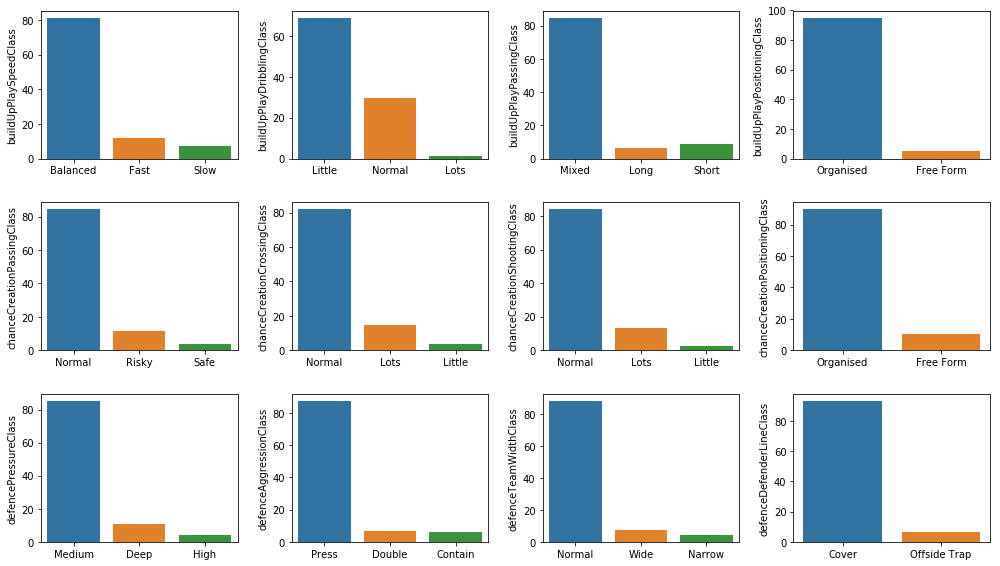

In [33]:
### List 8 Numerical Team Attributes:
print(tat.select_dtypes(include = ["int64"]).columns.tolist())

fig9, ax9 = plt.subplots(nrows=3, ncols=4)
fig9.set_size_inches(14,8)

for i,j in enumerate(DFs['dfTeam_Attributes_Updated'].select_dtypes(include = ['object']).columns[1:].tolist()):
  sns.barplot(x = j, y = j, data = tat,
              estimator = lambda x: len(x)/len(tat) * 100, ax = ax9[int(i/4)][i%4],
              orient = 'v')
  ax9[int(i/4)][i%4].set(xlabel = "")

fig9.tight_layout()

## <a id='eda'></a> Exploratory Data Analysis

I used Pandas DataFrame merge() to combine data in different dataframes and present analyses in diagrams.

Among seven dataframes,
 - Players and Teams are the targets to understand.
   Both combined with their corresponding attributes dataframes can provide certain insight in their domain;
 - Matches are records of archievement.
   To compare or evaluate how well Players, Teams and Leagues performed we blend in Matches and make prediction.
 - Countries and Leagues are the base for grouping. They serve as scopes for corresponding analyses.

Exploratory analyses are where I present merged data from different dataframes using visualization techniques.   

### <a id='evaluating_players'></a> Evaluating Players

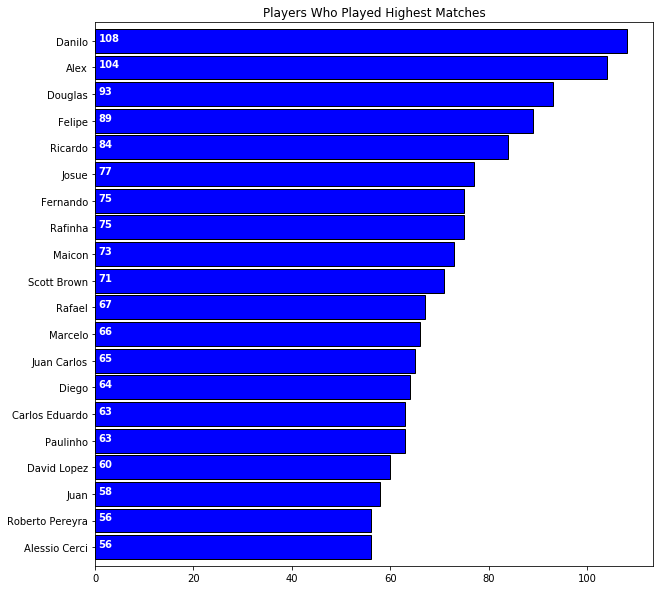

In [34]:
## merge player data with player attributes
DFs['dfPlayers'] = DFs['dfPlayer_Attributes'].merge(DFs['dfPlayer'],
                                                    left_on="player_api_id",
                                                    right_on="player_api_id",
                                                    how="left")

ignoredPlayerAttrs =["id_x", "id_y", 'player_fifa_api_id_y', 'height', 'weight',
                     'weight_kg', 'height_m', 'bmi', 'year', 'age', 'birthday']

DFs['dfPlayers_WithSelectedAttrs'] = DFs['dfPlayers'][
                                        [x for x in DFs['dfPlayers'].columns if x not in ignoredPlayerAttrs]]

DFs['dfPlayers_WithSelectedAttrs']["date"] = pd.to_datetime(DFs['dfPlayers_WithSelectedAttrs']["date"],
                                                            format="%Y-%m-%d")

###  Players Who Played in Most Games
ax = DFs['dfPlayers_WithSelectedAttrs']["player_name"].value_counts().sort_values()[-20:].plot(
  kind="barh", figsize=(10,10), color="b",width=.9, linewidth = 1, edgecolor = "k"*20)

for i,j in enumerate(DFs['dfPlayers_WithSelectedAttrs']["player_name"].value_counts().sort_values()[-20:].values):
  ax.text(.7, i, j, weight = "bold", color="white")
ax.set_title("Players Who Played Highest Matches")
plt.show()

### <a id='player_overallrating_corr'></a> Does Player's "Overall Rating" depend on any Player Attribute(s)?
Scatter plots reveal the correlation among attributes in a dataset.

Here we see scatter plots between "overall rating" and a list of selected player attributes. Values on "potential" and "reactions" attributes appear to have correlation with "overall rating".

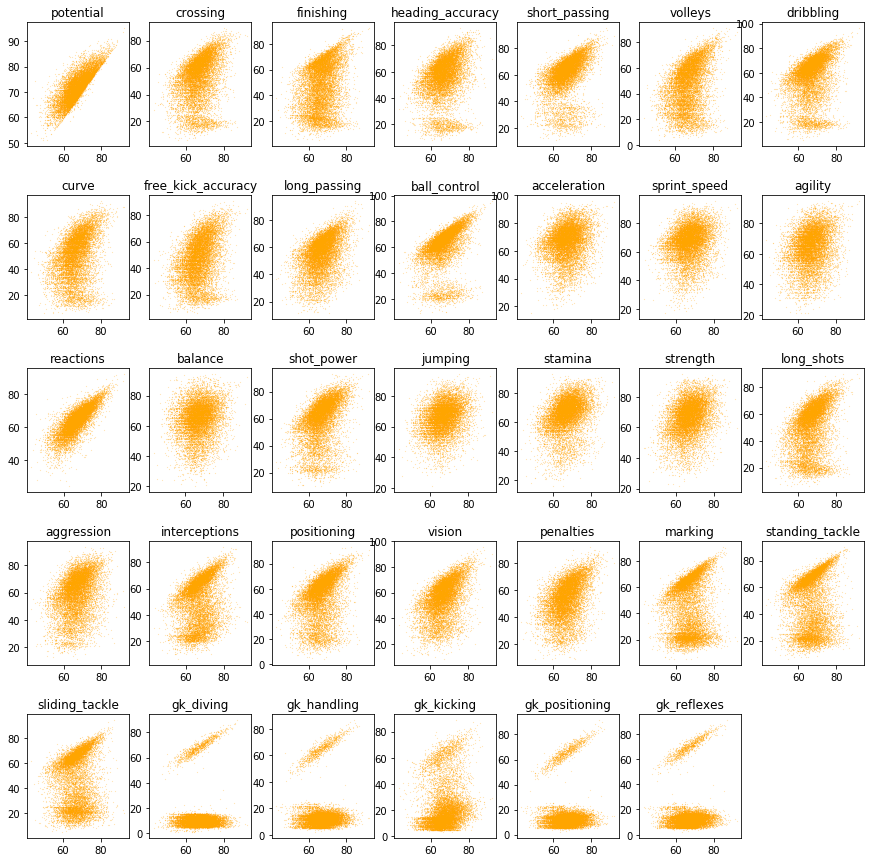

In [35]:
### scatter plot for overall rating and player attributes
playerAttrs = ["player_api_id",'overall_rating',
       'potential','crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']

x = DFs['dfPlayer_Attributes'][playerAttrs]
x = x.groupby("player_api_id")[playerAttrs].mean()
x = x.drop("player_api_id", axis =1).reset_index().drop("player_api_id",axis=1)

selectedPlayerAttrs = ['potential','crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes' ]

length = len(selectedPlayerAttrs)
plt.figure(figsize=(15,15))

for i,j in itertools.zip_longest(selectedPlayerAttrs, range(length)):
  plt.subplot(5,7,j+1)
  plt.scatter(x["overall_rating"], x[i], s=.01, color="Orange")
  plt.title(i)
  plt.subplots_adjust(hspace =.4)


### <a id='top_overall_rating_players'></a> Comparing Skills Among Players with Top Overall_Rating?

**What are the similarities and differences in terms of skills among Top Overall_Rating Players?**

Radar charts are an effective tool to visualize the differences among selected attributes. Not only can they be used to identify strengths and weaknesses of a subject radar charts show performance gaps when they're used to compare the same set of attributes among subjects. In this section I used radar charts to compare 30 selected attritbues based on top players and a specific criteria. In addition to identify the performance gaps and strengths and weaknesses we can also use them to see possible paradigm shift when we compare the data in different time. 

In this section, I defined the Top-Player criteria as "overall_rating greater than 91.0". It returned 6 players. Each top-rated player's radar charts consisted of 30 attributes. Eight radar charts were present below.

- Cristiano Ronaldo,
- Gianluigi Buffon,
- Gregory Coupet,
- Lionel Messi,
- Wayne Rooney,
- Xavi Hernandez

If my Top-Player criteria changed to "ball_control greater than 94.0" I got 8 players instead. Follow the same practice. With the change on top-player criteria we can gain an understanding of our players     

Based on the "overall_rating greater than 91.0" criteria we have 6 "top players". My observations are,
- All selected players got high scores on their "potentials" and "reactions" as suggested in scatter matrix.
- Three patterns of radar charts. It turns out the difference on their skill spectrum has to do with their positions in their teams:
 - Gianluigi Buffon and Gregory Coupet are in "GoalKeeper" position;
 - Xavi Hernandez, "Midfielder";
 - And, C Ronaldo, L Messi and W Rooney are Forward.

Since goal keeper related attributes were not selected Buffon and Coupet radar charts appeared "weak" while their overall ratings were high. Compared the only Midfielder with the rest of three Forwards, we saw:
 - Hernandez was strong on "sliding tackle", "standing tackle", and "interception" which are essential skills for a great Midfielder.
 - While three Forwards, C Ronaldo, L Messi, and W Rooney, possesed comprehensive skills they shared the same pattern of getting relatively low score on "sliding tackle", "standing tackle", and "interception".
 
Positions influence radar charts.
- Forwards and Midfielders shared a lot in common and were strong in most areas, such as Ball Control, Dribbling and Balance, etc.
- Midfielders usually scored higher in Tackles and Interception compared with Forwards. Andres Iniesta, another great Midfielder, possesed the same character as Hernandez'.
- Forwards were strong on Acceleration, Finishing, Agility, Reactions, and Shot Power, etc.


Top-6 players in terms of overall_rating over 91.0:
Cristiano Ronaldo,
Gianluigi Buffon,
Gregory Coupet,
Lionel Messi,
Wayne Rooney,
Xavi Hernandez


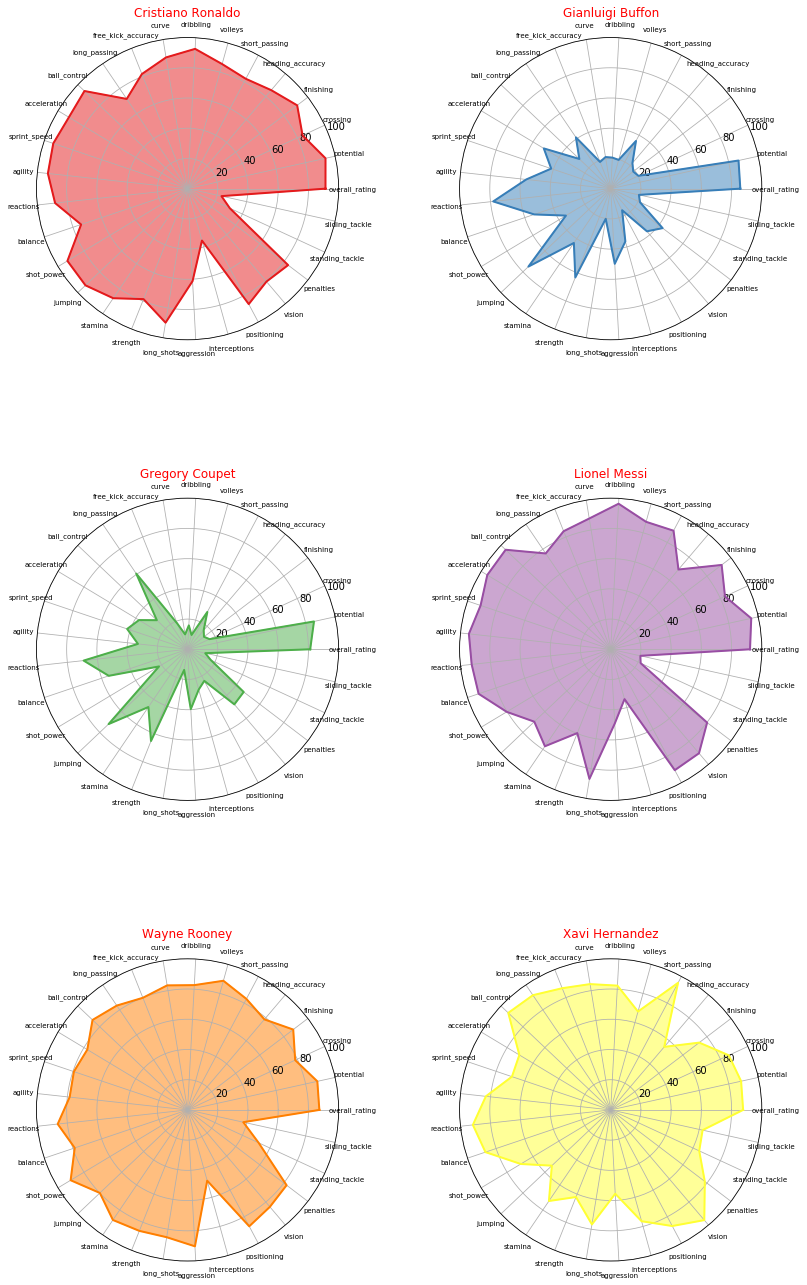

In [36]:
### Radar Chart for Top Players and their Attributes

keyAttr, mgnAttr = 'overall_rating', 91.0     ## Selected Attribute, Margin of Attribute
## keyAttr, mgnAttr = 'ball_control', 94.0

topRatedPlayers = DFs['dfPlayers_WithSelectedAttrs'][getattr(DFs['dfPlayers_WithSelectedAttrs'], keyAttr) > mgnAttr ]

topRatedPlayers = topRatedPlayers['player_name'].unique()
numTopRatedPlayers = len(topRatedPlayers)
print("Top-{} players in terms of {} over {}:\n{}".format(numTopRatedPlayers,
                                                          keyAttr,
                                                          mgnAttr,
                                                          ",\n".join(topRatedPlayers)))

num_l = [i for i in range(numTopRatedPlayers)]

play   = DFs['dfPlayers_WithSelectedAttrs'][ DFs['dfPlayers_WithSelectedAttrs']["player_name"].isin(topRatedPlayers)]

selectedPlayerAttrs   = ["player_name", 'overall_rating','potential', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'standing_tackle', 'sliding_tackle']

play = play[selectedPlayerAttrs]
play = play.groupby("player_name")[selectedPlayerAttrs].mean().reset_index()

cplt       = sns.color_palette("Set1", numTopRatedPlayers)

plt.figure(figsize=(13,23))

col = 2
row = int(numTopRatedPlayers / col)
if numTopRatedPlayers > row * col:
  row += 1 

for i, j, k in itertools.zip_longest(num_l, range(numTopRatedPlayers), cplt):

  plt.subplot( row , col , j + 1, projection="polar")
  cats = list(play)[1:]
  N    = len(cats)  
    
  values = play.loc[i].drop("player_name").values.flatten().tolist()
  values += values[:1]
  values
  angles = [n / float(N) * 2 * pi for n in range(N)]
  angles += angles[:1]
  angles
    
  plt.xticks(angles[:-1],cats,color="k",size=7)
  plt.ylim([0,100])
  plt.plot(angles, values, color=k, linewidth=2, linestyle="solid")
  plt.fill(angles, values, color=k, alpha=0.5)
  plt.title(play["player_name"][i], color="r")
  plt.subplots_adjust(wspace=.4, hspace=.4)


### Compare Top "Overall Rating" Players Using Bar Charts
Use Bar charts to visualize and compare the skills among top overall_rating players. 

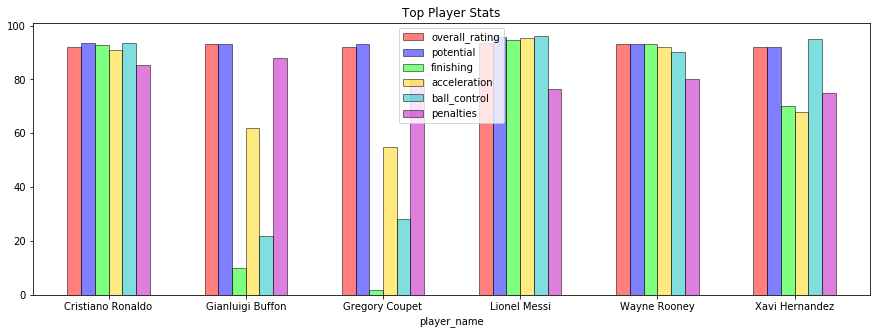

In [37]:
### TOP Overall Rating PLAYERS STATS (rating > 91)
top_rated = DFs['dfPlayers_WithSelectedAttrs'][ DFs['dfPlayers_WithSelectedAttrs']["overall_rating"]  > 91 ]
top_rated = top_rated[['player_name', 'player_api_id', 'date', 'overall_rating', 'potential','finishing',
                       'acceleration', 'ball_control', 'penalties']]
top_rated = top_rated.groupby("player_name").agg({'overall_rating':"mean",
                                                  'potential':"mean",
                                                  'finishing':"mean",
                                                  'acceleration':"mean",
                                                  'ball_control':"mean" ,
                                                  'penalties':"mean"})

top_rated.plot(kind="bar", width=.6, figsize=(15,5), colors=["r","b","lime","gold","c","m"],
               alpha=.5, linewidth = 1,edgecolor = "k"*6)

plt.title("Top Player Stats")
plt.xticks(rotation = 0)
plt.legend(loc ="Lower Center")
plt.show()

### <a id='wordCloud_overallrating_88_players'></a> Word Cloud of High Overall Rating Players
**Create a Word Cloud for players with Overall Rating beyond 88**

Although a Word Cloud doesn't carry much statistics info it is an intuitive way to present the frequency of all words in a selected text. As shown below, top rated players, such as L. Messe, C. Ronaldo, F. Ribery, and L. Suarez, etc., stand out from other names. I also printed out a list of tuples with their names and the counts for verification purpose.   

Rating of Top Players:
 [('Lionel Messi', 24), ('Cristiano Ronaldo', 24), ('Andres Iniesta', 15), ('Franck Ribery', 12), ('Zlatan Ibrahimovic', 11), ('Luis Suarez', 11), ('Robin van Persie', 11), ('Iker Casillas', 9), ('Manuel Neuer', 9), ('Arjen Robben', 8), ('Xavi Hernandez', 7), ('Wayne Rooney', 6), ('Radamel Falcao', 6), ('Gianluigi Buffon', 4), ('Neymar', 4), ('Nemanja Vidic', 3), ('Kaka', 3), ('Petr Cech', 2), ('Cris', 2), ('Ze Roberto', 2), ('Eden Hazard', 2), ("Samuel Eto'o", 2), ('Ronaldinho', 2), ('David Villa', 2), ('Alessandro Nesta', 2), ('John Terry', 2), ('Thierry Henry', 2), ('Julio Cesar', 2), ('David Trezeguet', 1), ('Carles Puyol', 1), ('Gregory Coupet', 1), ('Adriano', 1), ('Francesco Totti', 1), ('Frank Lampard', 1), ('Steven Gerrard', 1), ('Cesc Fabregas', 1), ('Fabio Cannavaro', 1), ('Luca Toni', 1), ('Lucio', 1)]


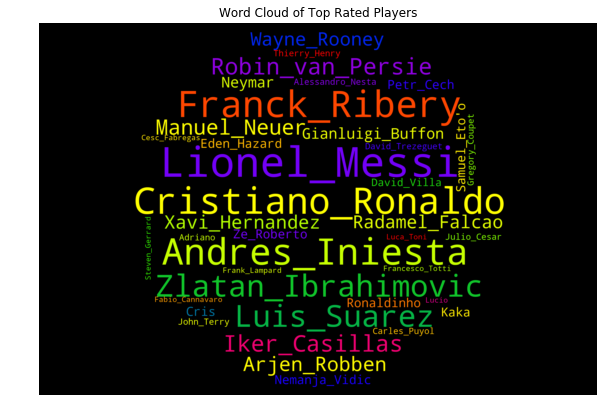

In [38]:
## Top Players
topRatedPlayers_l =  DFs['dfPlayers_WithSelectedAttrs'][DFs['dfPlayers_WithSelectedAttrs']["overall_rating"]  > 88 ]["player_name"].value_counts()

## (Player_Name, Won_Count) :
tplTopRatedPlayerNamesTimes = [ (i, topRatedPlayers_l[i]) for i in topRatedPlayers_l.index ]
print("Rating of Top Players:\n {}".format(tplTopRatedPlayerNamesTimes))

txtTopRatedPlayerNames = []
for i in topRatedPlayers_l.index:
  x = i.split()
  txtTopRatedPlayerNames.extend( ["_".join(x) if len(x) > 1 else x[0]] )

img = np.array(Image.open("input/picture-wrd/circle.jpg"))
               
wc = WordCloud(background_color="black",
               scale=3,
               mask=img,
               colormap="prism",
               max_words=100000).generate(" ".join(txtTopRatedPlayerNames))

fig = plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Top Rated Players")
plt.show()

### <a id='preferredfootproportion_players'></a> Preferred Foot and Top Overall Rating Players
**Does the proportion of preferred foot change between all players and top players with overall rating higher than 80?**

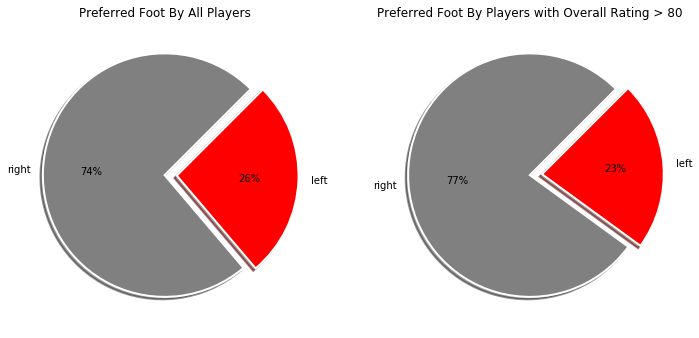

In [39]:
### Preferred Foot By Players
plt.figure(figsize=(12,6))

mgnTopOverallRating = 80

plt.subplot(121)
pf = DFs['dfPlayers_WithSelectedAttrs'].groupby(
  ["player_api_id", "preferred_foot"])["overall_rating"].mean().reset_index()["preferred_foot"].value_counts()

pf.plot.pie(autopct = "%1.0f%%", shadow = True, wedgeprops={"linewidth":2,"edgecolor":"white"},
            colors=["grey","r"], explode=[0,.1],startangle=45)

plt.title("Preferred Foot By All Players")
plt.ylabel("")

plt.subplot(122)
t_f = DFs['dfPlayers_WithSelectedAttrs'].groupby(
  ["player_api_id","preferred_foot"])["overall_rating"].mean().reset_index()

t_f[t_f["overall_rating"] > mgnTopOverallRating]["preferred_foot"].value_counts().plot.pie(
  autopct = "%1.0f%%", shadow = True, wedgeprops={"linewidth":2, "edgecolor":"white"}, colors=["grey","r"],
  explode=[0,.1], startangle=45)

plt.title("Preferred Foot By Players with Overall Rating > {}".format(mgnTopOverallRating))
plt.ylabel("")
plt.show()

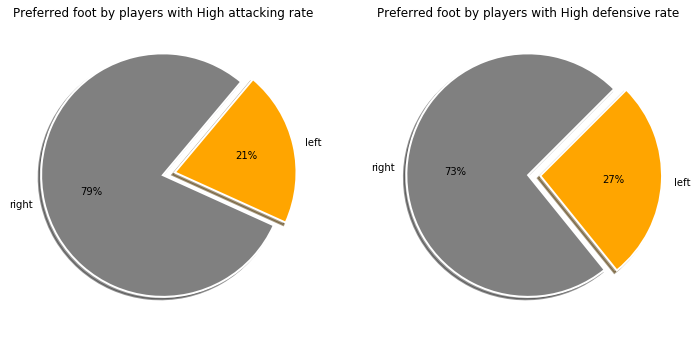

In [40]:
### Preferred Foot By Attackers vs Defenders

x = DFs['dfPlayers_WithSelectedAttrs'][ DFs['dfPlayers_WithSelectedAttrs']["attacking_work_rate"] == "low"]
x = x.groupby(["player_api_id","player_name","preferred_foot"])["date"].count().reset_index()

plt.figure(figsize=(12,6))

plt.subplot(121)
x["preferred_foot"].value_counts().plot.pie(autopct = "%1.0f%%", shadow = True,
                                            wedgeprops={"linewidth":2,"edgecolor":"white"},
                                            colors=["grey","orange"],explode=[0,.1],startangle=50)

plt.ylabel("")
plt.title("Preferred foot by players with High attacking rate")

x = DFs['dfPlayers_WithSelectedAttrs'][ DFs['dfPlayers_WithSelectedAttrs']["defensive_work_rate"] == "low"]
x = x.groupby(["player_api_id","player_name","preferred_foot"])["date"].count().reset_index()


plt.subplot(122)
x["preferred_foot"].value_counts().plot.pie(autopct = "%1.0f%%", shadow = True,
                                            wedgeprops={"linewidth":2,"edgecolor":"white"},
                                            colors=["grey","orange"],explode=[0,.1],startangle=45)

plt.ylabel("")
plt.title("Preferred foot by players with High defensive rate")

plt.show()

### <a id='player_comparator'></a> Player Comparator

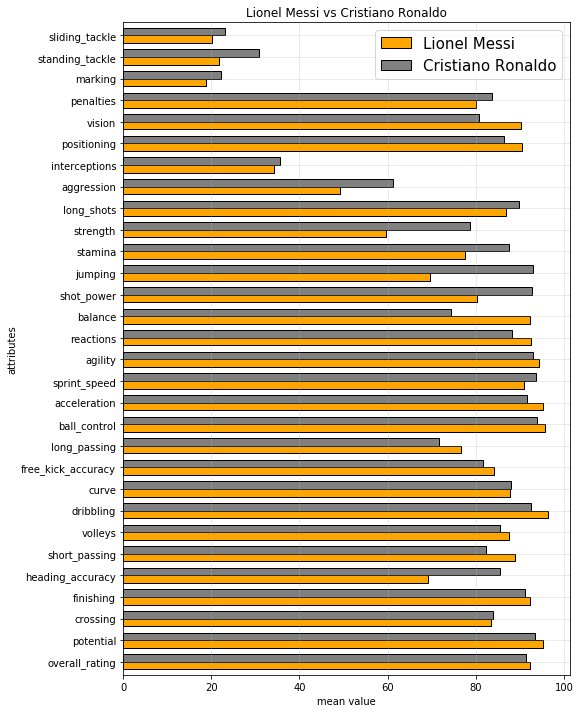

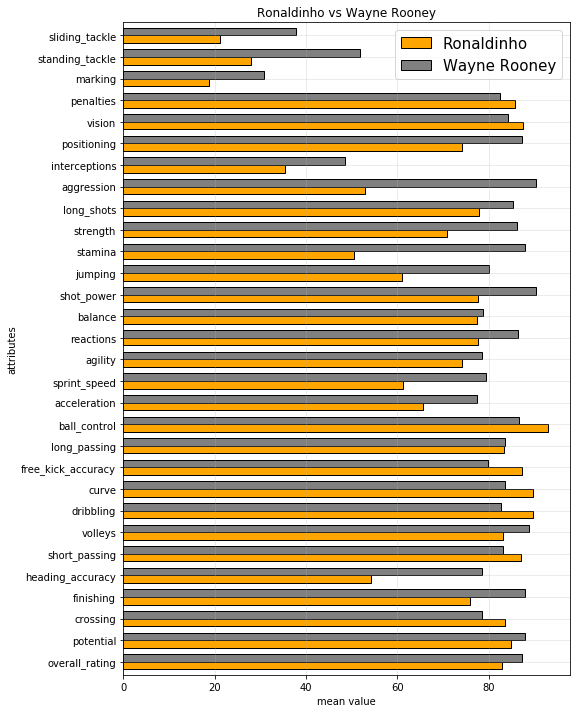

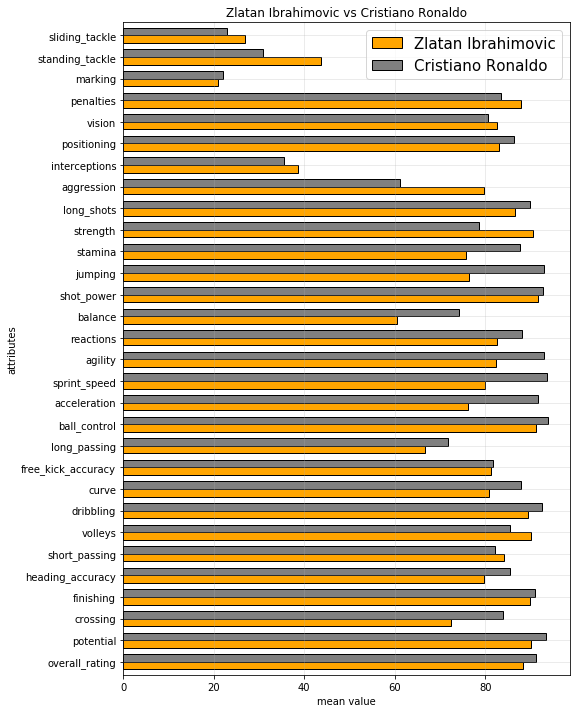

In [41]:
idx  = "player_api_id"
cols = ['overall_rating','potential', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle']

def player_comparator(player1, player2):
    
  x1 = DFs['dfPlayers_WithSelectedAttrs'][ DFs['dfPlayers_WithSelectedAttrs']["player_name"] == player1]
  x1 = x1.groupby(["player_name"])[cols].mean()
    
  x2 = DFs['dfPlayers_WithSelectedAttrs'][ DFs['dfPlayers_WithSelectedAttrs']["player_name"] == player2]
  x2 = x2.groupby(["player_name"])[cols].mean()
    
  z  = pd.concat([x1,x2]).transpose().reset_index()
  z  = z.rename( columns={"index":"attributes", player1:player1, player2:player2})
  z.index = z.attributes
  z[[player1,player2]].plot(kind = "barh",
                            figsize = (8,12),
                            colors = ["orange","grey"],
                            linewidth = 1 ,
                            width = .7,
                            edgecolor = ["k"]*z["attributes"].nunique()
                            )
  plt.xlabel("mean value")
  plt.legend(loc = "best",prop = {"size" : 15})
  plt.grid(True, alpha = .3)
  plt.title("{} vs {}".format(player1, player2))
  ## plt.title(player1+"  vs  "+player2)

# MESSI VS RONALDO
player_comparator('Lionel Messi','Cristiano Ronaldo')

## 'Ronaldinho' & 'Wayne Rooney'
player_comparator( 'Ronaldinho','Wayne Rooney')

## 'Zlatan Ibrahimovic' & 'Cristiano Ronaldo'
player_comparator('Zlatan Ibrahimovic','Cristiano Ronaldo')

### Goal Keeper

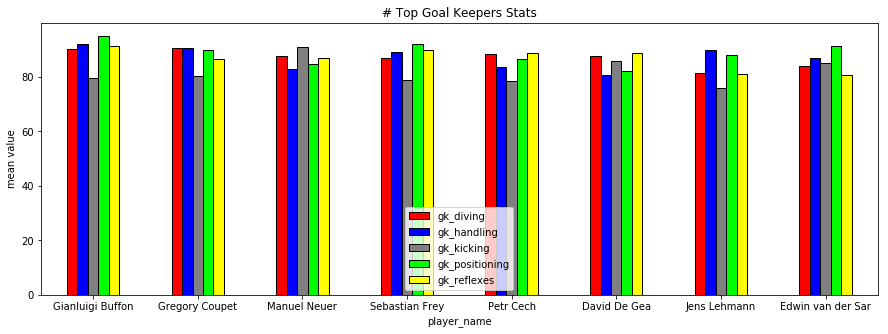

In [42]:

## goal_keeper == DFs['dfGoalKeeper']
DFs['dfGoalKeeper'] = DFs['dfPlayers_WithSelectedAttrs'][["player_api_id",'gk_diving', 'gk_handling', 'gk_kicking',
                                                          'gk_positioning','gk_reflexes', 'player_name',
                                                          "overall_rating"]]

DFs['dfGoalKeeper'] = DFs['dfGoalKeeper'][(DFs['dfGoalKeeper']["gk_diving"] > 75) &
                                          (DFs['dfGoalKeeper']["gk_handling"] > 75) &
                                          (DFs['dfGoalKeeper']["gk_kicking"] > 75) &
                                          (DFs['dfGoalKeeper']["gk_positioning"] > 75) &
                                          (DFs['dfGoalKeeper']["gk_reflexes"] > 75) ]

DFs['dfGoalKeeper'] = DFs['dfGoalKeeper'].groupby(
  ["player_api_id", "player_name"])[['gk_diving', 'gk_handling', 'gk_kicking',
                                     'gk_positioning', 'gk_reflexes', 'overall_rating']].mean()

DFs['dfGoalKeeper'] = DFs['dfGoalKeeper'].sort_values(by="overall_rating", ascending =False).reset_index()
DFs['dfGoalKeeper'].index = DFs['dfGoalKeeper']["player_name"]
DFs['dfGoalKeeper']


### Top Goal Keepers Stats
DFs['dfGoalKeeper'][['gk_diving', 'gk_handling', 'gk_kicking',
       'gk_positioning', 'gk_reflexes']][:8].plot(kind = "bar", figsize=(15,5),
                                                  color =["r","b","grey","lime","yellow"],
                                                  linewidth = 1, edgecolor = "k"*10 )

plt.xticks(rotation =0)
plt.legend(loc ="lower center")
plt.ylabel("mean value")
plt.title("# Top Goal Keepers Stats")
plt.show()


### DISTRIBUTION OF TEAM ATTRIBUTES AMONG TEAMS


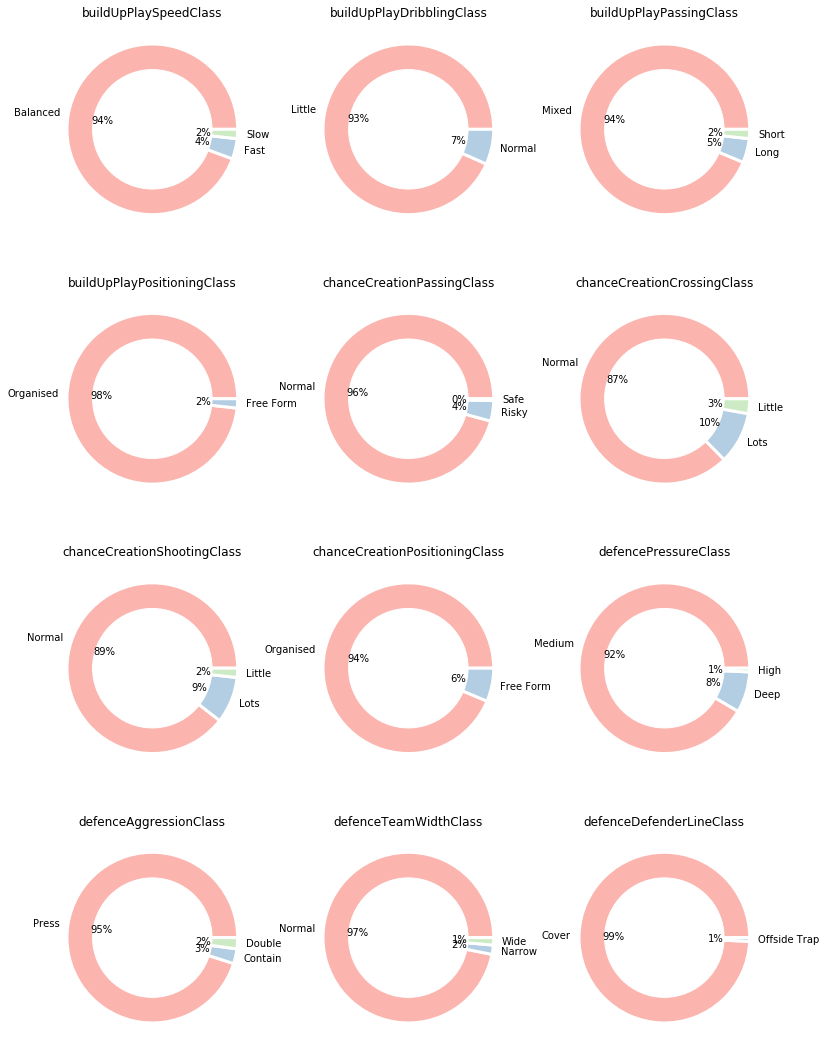

In [43]:
### Merge Teams with Team Attributes
DFs["dfTeams"] =  DFs["dfTeam_Attributes"].merge(DFs["dfTeam"],
                                                 left_on="team_api_id",
                                                 right_on="team_api_id",
                                                 how="left")

DFs["dfTeams_Refined"] = DFs["dfTeams"].drop(['id_x','id_y', 'team_fifa_api_id_y'], axis=1)
DFs["dfTeams_Refined"]["date"] = pd.to_datetime(DFs["dfTeams_Refined"]["date"], format="%Y-%m-%d")

columns = DFs["dfTeams_Refined"].columns

cat_col = columns[ columns.str.contains("Class") ].tolist()
num_col= [x for x in DFs["dfTeams_Refined"].columns if x not in columns[columns.str.contains("Class")].tolist() + 
          ["team_api_id"] + ['team_fifa_api_id_x'] + ["date"] + ['team_long_name'] + ['team_short_name']]

TeamMark_l = ["team_api_id"]+['team_fifa_api_id_x']+["date"]+['team_long_name']+[ 'team_short_name']

categorical_team_info = DFs["dfTeams_Refined"][cat_col + TeamMark_l]
numerical_team_info   = DFs["dfTeams_Refined"][num_col + TeamMark_l]

numerical_team_info


# from scipy.stats import mode
c = categorical_team_info.groupby("team_long_name").agg({"buildUpPlaySpeedClass":lambda x:mode(x)[0],
                                                    "buildUpPlayDribblingClass":lambda x:mode(x)[0],
                                                    'buildUpPlayPassingClass':lambda x:mode(x)[0],
                                                    'buildUpPlayPositioningClass':lambda x:mode(x)[0],
                                                    'chanceCreationPassingClass':lambda x:mode(x)[0],
                                                    'chanceCreationCrossingClass':lambda x:mode(x)[0],
                                                     'chanceCreationShootingClass':lambda x:mode(x)[0],
                                                     'chanceCreationPositioningClass':lambda x:mode(x)[0],
                                                     'defencePressureClass':lambda x:mode(x)[0],
                                                     'defenceAggressionClass':lambda x:mode(x)[0],
                                                     'defenceTeamWidthClass':lambda x:mode(x)[0],
                                                     'defenceDefenderLineClass':lambda x:mode(x)[0]}).reset_index()

cat_col
plt.figure(figsize=(13,19))
for i,j in itertools.zip_longest(cat_col,range(len(cat_col))):
    plt.subplot(4,3,j+1)
    plt.pie(c[i].value_counts().values,labels=c[i].value_counts().keys(),
            wedgeprops={"linewidth":3,"edgecolor":"w"},
           colors=sns.color_palette("Pastel1"), autopct = "%1.0f%%")
    my_circ = plt.Circle((0,0),.7,color="white")
    plt.gca().add_artist(my_circ)
    plt.title(i)
    plt.xlabel("")

### Top Teams by Team Attributes
This section visualized the ranks of teams in each numerical team attributes. Same technique can apply to play attributes.

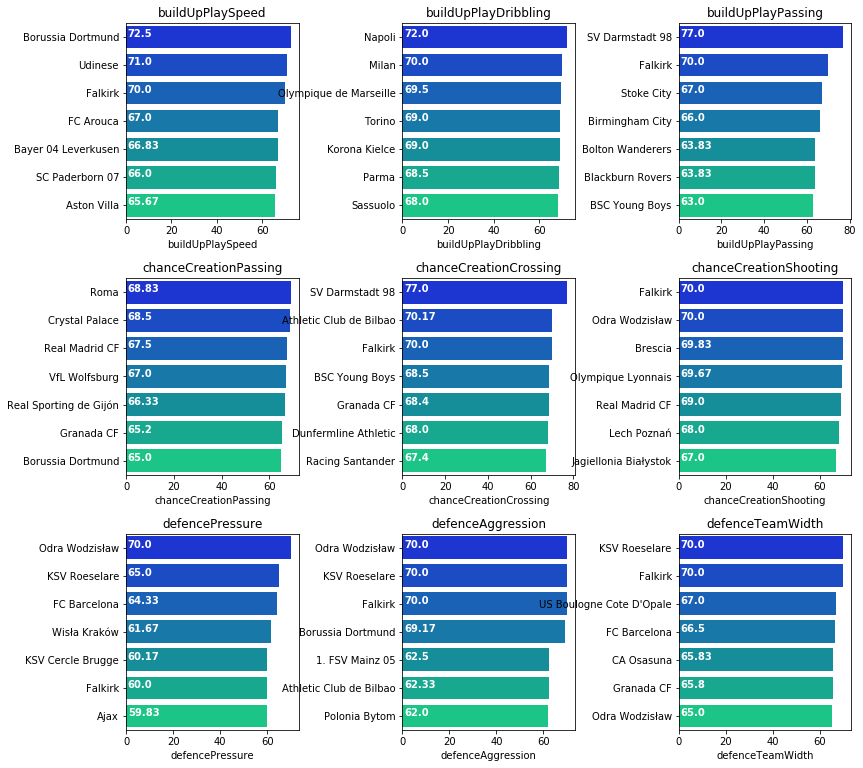

In [44]:
### Top Teams by Team Attributes

n = numerical_team_info.groupby("team_long_name")[num_col].mean().reset_index()
cols = [x for x in n.columns if x not in ["team_long_name"]]

length = len(cols)

plt.figure(figsize=(13,13))

for i,j in itertools.zip_longest(cols, range(length)):
  plt.subplot(length/3, length/3, j+1)
  ax = sns.barplot(i, "team_long_name", data=n. sort_values(by=i, ascending=False)[:7], palette="winter")
  plt.title(i)
  plt.subplots_adjust(wspace = .6, hspace =.3)
  plt.ylabel("")
    
  for i,j in enumerate(round(n.sort_values(by = i,ascending=False)[i][:7],2)):
    ax.text(.7,i,j,weight = "bold",color="white") 

### <a id='team_comparator'></a> Team Comparator
Build a comparator to compare the performance and capabilities between two team. Nine categories were chosen as the key measurement. Radar charts create an intuitive graph to present the strengths and weaknesses between two teams.

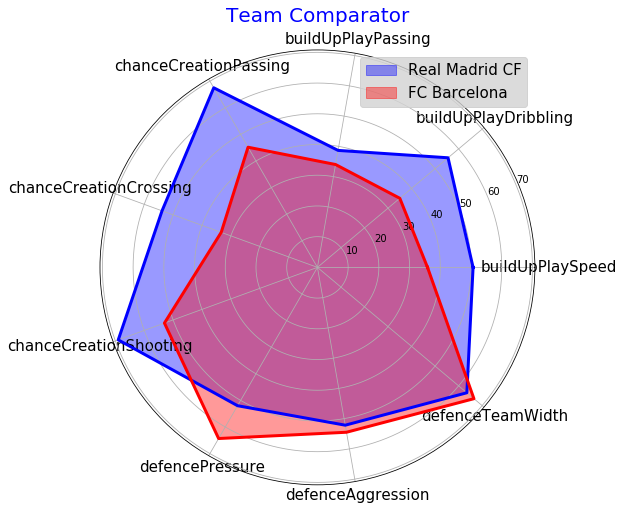

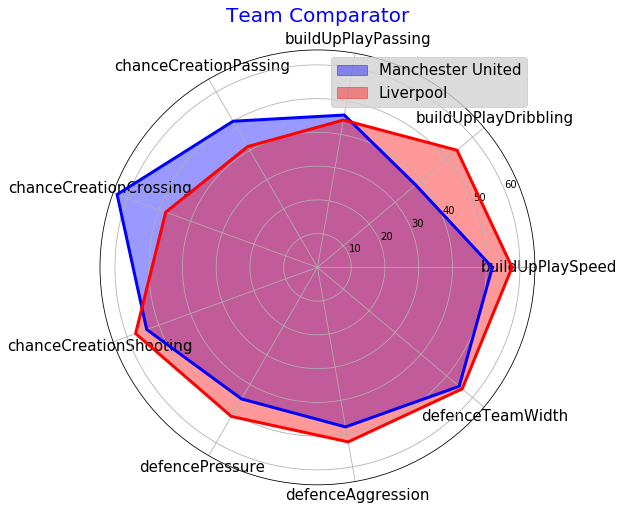

In [45]:
### TEAM COMPARATOR
def team_comparator(team1,team2):
  team_list = [team1, team2]
  length    = len(team_list)
  cr        = ["b","r"]
  fig = plt.figure(figsize=(10,8))
  plt.subplot(111,projection= "polar")

  for i,j,k in itertools.zip_longest(team_list,range(length),cr):
    cats = num_col
    N    = len(cats)
        
    values = n[n["team_long_name"] ==  i][cats].values.flatten().tolist()
    values += values[:1]
        
    angles = [n/float(N)*2*pi for n in range(N)]
    angles += angles[:1]
        
    plt.xticks(angles[:-1],cats,color="k",fontsize=15)
    plt.plot(angles,values,linewidth=3,color=k)
    plt.fill(angles,values,color = k,alpha=.4,label = i)
    plt.legend(loc="upper right",frameon =True,prop={"size":15}).get_frame().set_facecolor("lightgrey")
    fig.set_facecolor("w")
    fig.set_edgecolor("k")
    plt.title("Team Comparator", fontsize=20, color="blue")

### Real Madrid CF vs. FC Barcelona:
team_comparator("Real Madrid CF","FC Barcelona")

### Manchester United vs Liverpool:
team_comparator("Manchester United","Liverpool")

### About Matches - Merge Matches with Leagues and Countries  

In [46]:
## Merge Country and leauge DataFrames

DFs["dfCountryLeague"] = DFs['dfCountry'].merge(DFs['dfLeague'], left_on="id", right_on="id", how="outer")
DFs["dfCountryLeague"] = DFs["dfCountryLeague"].drop("id", axis=1)
DFs["dfCountryLeague"] = DFs["dfCountryLeague"].rename(columns={'name_x':"country", 'name_y':"league"})

print(DFs["dfCountry"].head())
print(DFs["dfLeague"].head())
DFs["dfCountryLeague"].head()

      id     name
0      1  Belgium
1   1729  England
2   4769   France
3   7809  Germany
4  10257    Italy
      id  country_id                    name
0      1           1  Belgium Jupiler League
1   1729        1729  England Premier League
2   4769        4769          France Ligue 1
3   7809        7809   Germany 1. Bundesliga
4  10257       10257           Italy Serie A


country  country_id                  league
0  Belgium           1  Belgium Jupiler League
1  England        1729  England Premier League
2   France        4769          France Ligue 1
3  Germany        7809   Germany 1. Bundesliga
4    Italy       10257           Italy Serie A

In [47]:
## Select attributes to form a new Match dataframe
DFs['dfMatch_New'] = DFs['dfMatch'][['id', 'country_id', 'league_id', 'season', 'stage', 'date',
                   'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']]

DFs['dfMatch_New'] = DFs['dfMatch_New'].drop("id", axis=1)

print("Dimension of dfMatch: {} vs dfMatch_New: {}".format(DFs['dfMatch'].shape, DFs['dfMatch_New'].shape))
## DFs['dfMatch_New'].head()

Dimension of dfMatch: (25979, 115) vs dfMatch_New: (25979, 10)


In [48]:
## Merge leauge DataFrame with Match
## data = matches_new.merge(countries_leagues,left_on="country_id",right_on="country_id",how="outer")
dfMatchCountryLeague = DFs["dfMatch_New"].merge(DFs["dfCountryLeague"],
                                                left_on="country_id",
                                                right_on="country_id", how="outer")

## check null values
dfMatchCountryLeague.isna().sum()

country_id          0
league_id           0
season              0
stage               0
date                0
match_api_id        0
home_team_api_id    0
away_team_api_id    0
home_team_goal      0
away_team_goal      0
country             0
league              0
dtype: int64

In [49]:
## Unique values in dfMatchCountryLeague DataFrame
dfMatchCountryLeague.nunique()

country_id             11
league_id              11
season                  8
stage                  38
date                 1694
match_api_id        25979
home_team_api_id      299
away_team_api_id      299
home_team_goal         11
away_team_goal         10
country                11
league                 11
dtype: int64

### Geographic Location Visualization
This section I experiecned the basemap.Basemap module to get a visual on where these matches were hold around the globe.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


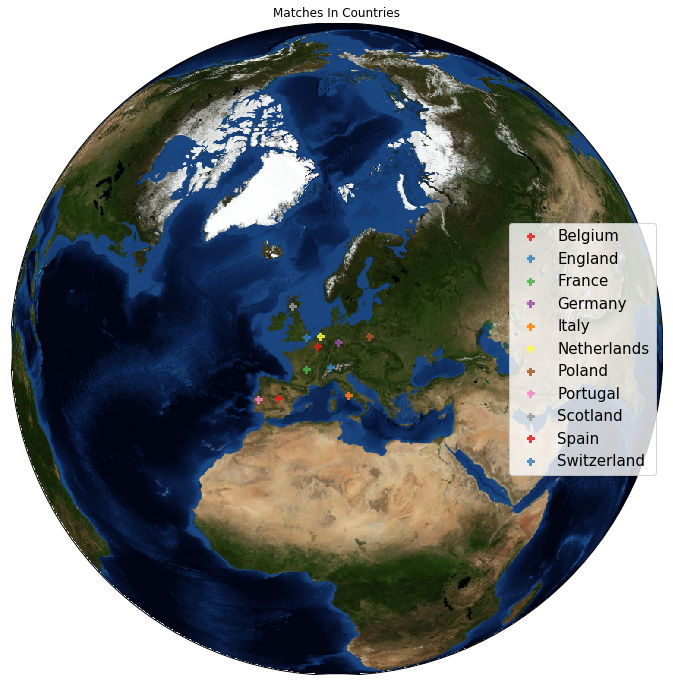

In [50]:
## Import Latitude and Longitude info:
DFs['dfLatLong'] = pd.read_excel("input/latlongSoccer.xlsx", sheetname = "Sheet1")

## Blend in the Latitude / Longitude info to mark on geographic globe map:
## Ref. https://www.kaggle.com/pavanraj159/european-football-data-analysis

DFs['dfGeoCountry'] = DFs['dfCountryLeague'].merge(DFs['dfLatLong'], left_on="country", right_on="name", how="left")
DFs['dfGeoCountry'] = DFs['dfGeoCountry'].drop(["country_id", "country_y", "name"], axis = 1)

baseMap = Basemap(projection='ortho', resolution=None, lat_0=50, lon_0=10, urcrnrlat=80, llcrnrlat=-80)

plt.figure(figsize=(12,12))

country = list(DFs['dfGeoCountry']["country_x"].unique())
cplt    = sns.color_palette("Set1", 11)
label   = country

def drawMap(country, cplt, label):
  '''Draw map by marking a Plus sign'''
  lat = list(DFs['dfGeoCountry'][DFs['dfGeoCountry']["country_x"] == country].latitude)
  lon = list(DFs['dfGeoCountry'][DFs['dfGeoCountry']["country_x"] == country].longitude)
  x, y = baseMap(lon, lat)
  baseMap.plot(x, y, "P", markersize=7, color=j, alpha=.8, label=i)

for i,j in zip(country, cplt):
  drawMap(i, j, i)

baseMap.bluemarble(scale=0.5)

plt.legend(loc="center right", frameon=True, prop={"size":15}).get_frame().set_facecolor("white")
plt.title("Matches In Countries")
plt.show()

### Where Were the Leagues Located in Europe?

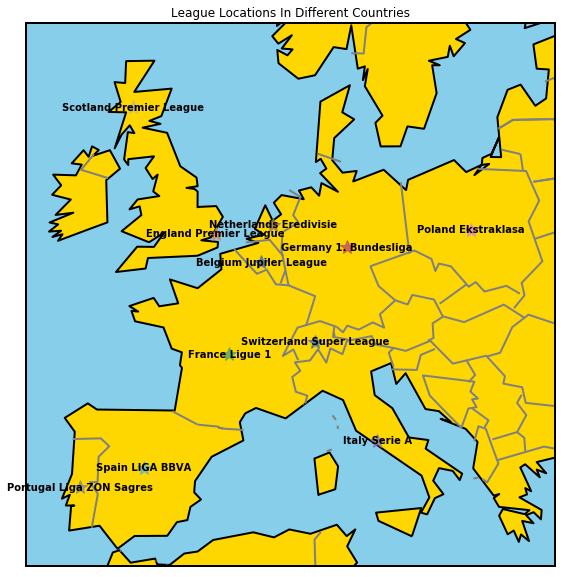

In [51]:
baseMap01 = Basemap(projection="merc", llcrnrlat=35, urcrnrlat=60,
                    llcrnrlon=-12, urcrnrlon=25, lat_ts=20, lat_0=True, lon_0=True)

plt.figure(figsize=(15,10))

baseMap01.drawmapboundary(fill_color="skyblue",color="k",linewidth=2)
baseMap01.drawcoastlines(linewidth=2)
baseMap01.drawcountries(linewidth=2, color="grey")
baseMap01.fillcontinents(color="gold", alpha=1, lake_color="b")

lea = list(DFs['dfGeoCountry']["league"].unique())
cplt = sns.color_palette("deep",11)
lat = list(DFs['dfGeoCountry'][DFs['dfGeoCountry']["league"] == lea].latitude)
lon = list(DFs['dfGeoCountry'][DFs['dfGeoCountry']["league"] == lea].longitude)
x, y  = baseMap01(lon,lat) 

def drawMapLeagueCountry(lea, cplt):
  lat = list(DFs['dfGeoCountry'][DFs['dfGeoCountry']["league"] == lea].latitude)
  lon = list(DFs['dfGeoCountry'][DFs['dfGeoCountry']["league"] == lea].longitude)
  x,y = baseMap01(lon, lat)
  baseMap01.plot(x, y, "*", markersize=15, color=j, alpha=.8, linewidth=20)
  ## baseMap01.plot(x, y, "go", markersize=10, color=j, alpha=.8, linewidth=20)
    
for i,j in zip(lea, cplt):
  drawMapLeagueCountry(i,j)
        
for i,j,k in itertools.zip_longest(x, y, DFs['dfGeoCountry']["league"]):
  plt.text(i, j, k, fontsize =10, color="k", horizontalalignment='center', verticalalignment='center', weight="bold")

plt.title("League Locations In Different Countries")
plt.show()

### Show the number of Matches played in each League

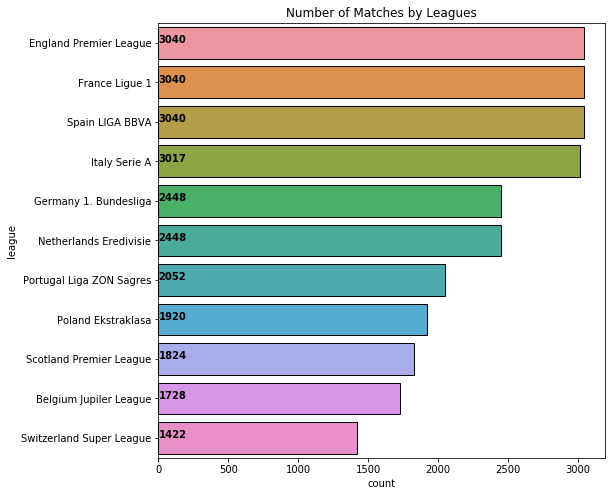

In [52]:
plt.figure(figsize=(8,8))

ax = sns.countplot(y = dfMatchCountryLeague["league"],
                   order = dfMatchCountryLeague["league"].value_counts().index,
                   linewidth = 1,
                   edgecolor = "k" * dfMatchCountryLeague["league"].nunique()
                 )

for i,j in enumerate(dfMatchCountryLeague["league"].value_counts().values):
  ax.text(.7, i, j, weight = "bold")

plt.title("Number of Matches by Leagues")
plt.show()

In [53]:
## Converting date format in the Matches by Countires and Leagues DataFrame 
dfMatchCountryLeague["date"] = pd.to_datetime(dfMatchCountryLeague["date"], format="%Y-%m-%d")

## Extracting year
dfMatchCountryLeague["year"] = pd.DatetimeIndex(dfMatchCountryLeague["date"]).year

### Matches played in each League by Season

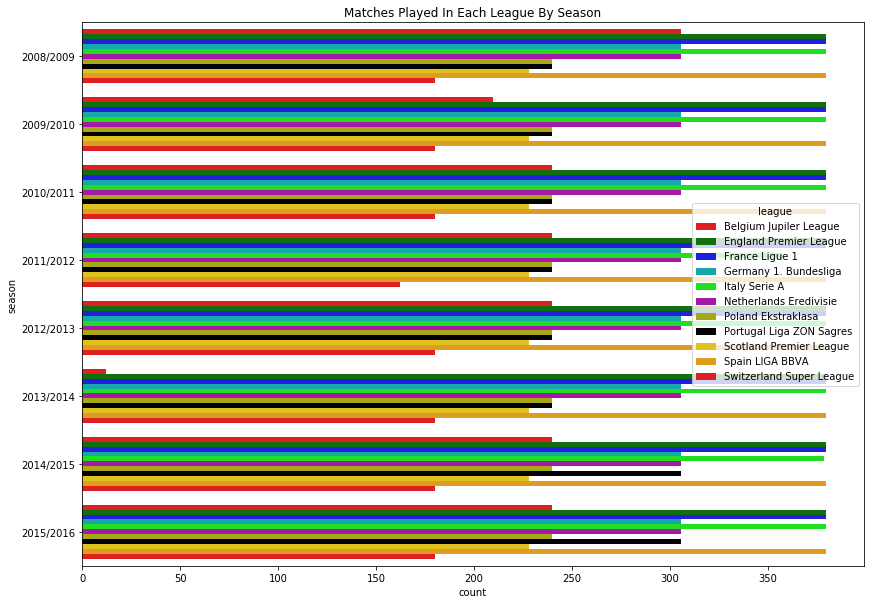

In [54]:
plt.figure(figsize=(14, 10))

sns.countplot(y = dfMatchCountryLeague["season"], hue=dfMatchCountryLeague["league"],
              palette=["r","g","b","c","lime","m","y","k","gold","orange"])

plt.title("Matches Played In Each League By Season")
plt.show()

### Does Home-Field Advantage Matter? 

To find out I need to blend in the Team dataframe with the previous Match-Country-League one.  

The dfMatch dataframe contains goals and match results. I want to see if "home advantage" exists by comparing average goals when teams were in their home fields vs when they were visiting.

We can see the average goal when teams were at Home is higher than the average when teams were visiting. The KDE chart does reveal, in general, "home advantage" exists in terms of goals.  

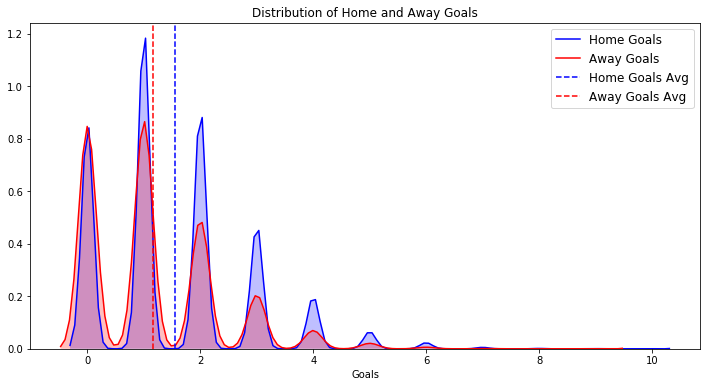

In [55]:
## Merge Home Team data:
dfMatchCountryLeague = dfMatchCountryLeague.merge(DFs['dfTeam'],
                                                  left_on="home_team_api_id",
                                                  right_on="team_api_id",
                                                  how="left")

dfMatchCountryLeague = dfMatchCountryLeague.drop(["id", "team_api_id", 'team_fifa_api_id'], axis = 1)

dfMatchCountryLeague = dfMatchCountryLeague.rename(columns={'team_long_name':"home_team_lname",
                                                                          'team_short_name':"home_team_sname"})

## Meerge Away Team data:
dfMatchCountryLeague = dfMatchCountryLeague.merge(DFs['dfTeam'],
                                                  left_on="away_team_api_id",
                                                  right_on="team_api_id",
                                                  how="left")

dfMatchCountryLeague = dfMatchCountryLeague.drop(["id","team_api_id",'team_fifa_api_id'],axis = 1)

dfMatchCountryLeague = dfMatchCountryLeague.rename(columns={ 'team_long_name':"away_team_lname",
                                                                          'team_short_name':"away_team_sname"})

### Distribution of Home and Away Goals
plt.figure(figsize=(12, 6))

sns.kdeplot(dfMatchCountryLeague["home_team_goal"], shade=True, color="b", label="Home Goals")
sns.kdeplot(dfMatchCountryLeague["away_team_goal"], shade=True, color="r", label="Away Goals")

plt.axvline(dfMatchCountryLeague["home_team_goal"].mean(), linestyle="dashed", color="b", label="Home Goals Avg")
plt.axvline(dfMatchCountryLeague["away_team_goal"].mean(), linestyle="dashed", color="r", label="Away Goals Avg")

plt.legend(loc="best", prop = {"size" : 12})
plt.title("Distribution of Home and Away Goals")
plt.xlabel("Goals")
plt.show()

### Home and Away goals in each League

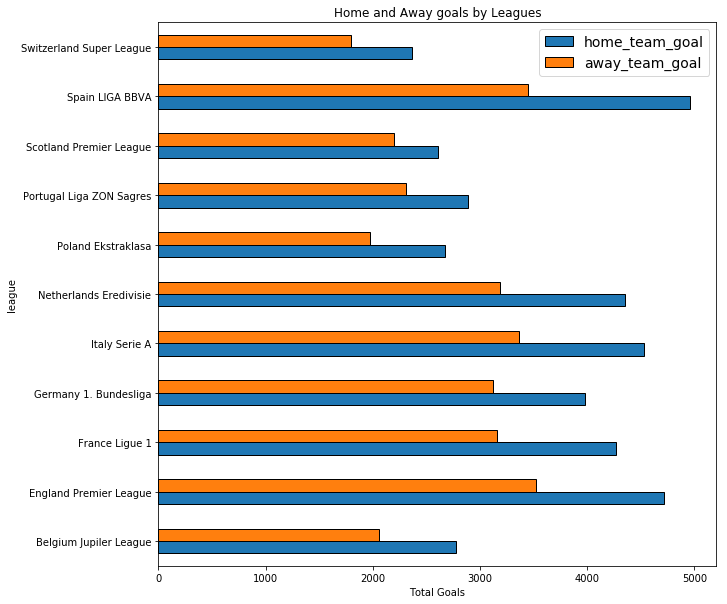

In [56]:
## Derive a Total_Goal feature: 
dfMatchCountryLeague["total_goal"] = dfMatchCountryLeague["home_team_goal"] + dfMatchCountryLeague["away_team_goal"]

## Gather goals by playing at home field vs in visiting:
dfMatchCountryLeague.groupby("league").agg({"home_team_goal":"sum", "away_team_goal":"sum"}).plot(kind="barh",
                                                                                 figsize = (10,10),
                                                                                 edgecolor = "k",
                                                                                 linewidth =1)
plt.title("Home and Away goals by Leagues")
plt.legend( loc= "best" , prop= {"size" : 14})
plt.xlabel("Total Goals")
plt.show()

### Top 20 Winning Teams and Goals, At Home vs. Away Visiting
This chart shows top 20 highest goals scored when teams played at home vs away from home. It depicts a fact that, home or not, top team performance remained balanced and competitive. Teams, such as Real Madrid FC, FC Barcelona, and Celtic, etc., took over the top 3 scores in both Home Goals and Away one.   

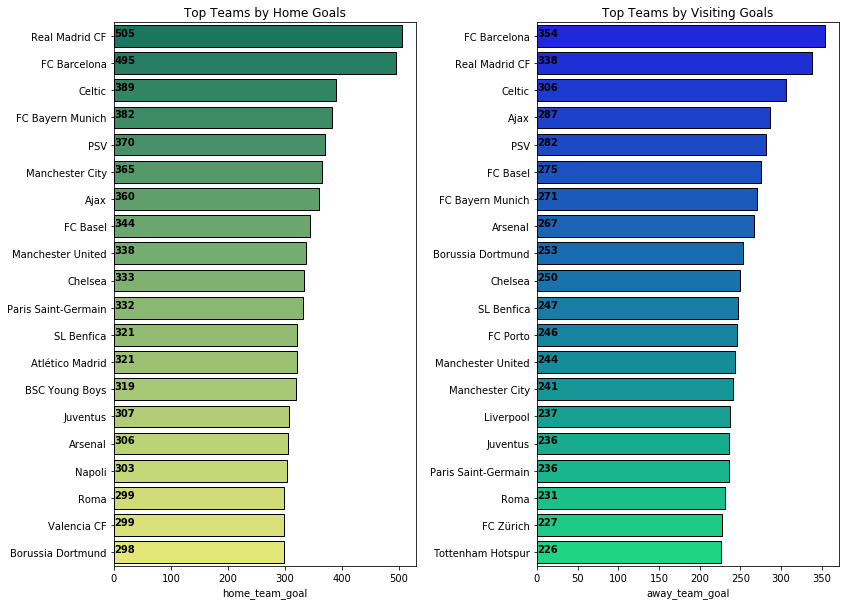

In [57]:
DFs['dfHomeTeam'] = dfMatchCountryLeague.groupby("home_team_lname")["home_team_goal"].sum().reset_index()
DFs['dfAwayTeam'] = dfMatchCountryLeague.groupby("away_team_lname")["away_team_goal"].sum().reset_index()

DFs['dfHomeTeam'] = DFs['dfHomeTeam'].sort_values(by="home_team_goal",ascending= False)
DFs['dfAwayTeam'] = DFs['dfAwayTeam'].sort_values(by="away_team_goal",ascending= False)

plt.figure(figsize=(13,10))
plt.subplot(121)

ax = sns.barplot(y="home_team_lname", x="home_team_goal", data=DFs['dfHomeTeam'][:20], palette="summer",
                 linewidth = 1, edgecolor = "k"*20)

plt.ylabel('')
plt.title("Top Teams by Home Goals")

for i,j in enumerate(DFs['dfHomeTeam']["home_team_goal"][:20]):
  ax.text(.7, i, j, weight = "bold")


plt.subplot(122)
ax = sns.barplot(y="away_team_lname", x="away_team_goal", data=DFs['dfAwayTeam'][:20],
                 palette="winter", linewidth = 1, edgecolor = "k"*20)

plt.ylabel("")
plt.subplots_adjust(wspace = .4)
plt.title("Top Teams by Visiting Goals")

for i,j in enumerate(DFs['dfAwayTeam']["away_team_goal"][:20]):
  ax.text(.7, i, j, weight = "bold")

### Proportion of Game Outcomes
This Pie chart shows the proportion of the parties. As we can see teams at home won 46% of the games compared with 29% and 25% of game ties in the past 8 years from 2008 to 2016. 

**Since teams at home claimed more victories than those in visit the pie chart suggested that "Home Advantage" exist.**

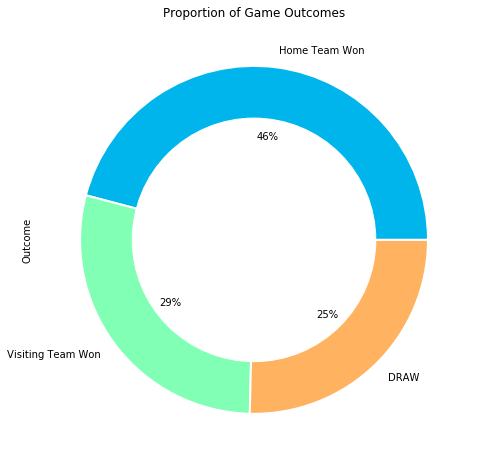

In [58]:
## New feature: Won; a new function to return the Winning team name
def lblWonTeam(df):
  '''Return the name of the Winning team'''
  if df["home_team_goal"] > df["away_team_goal"]:
    return df["home_team_lname"]
  elif df["away_team_goal"] > df["home_team_goal"]:
    return df["away_team_lname"]
  elif df["home_team_goal"] == df["away_team_goal"]:
    return "DRAW"

dfMatchCountryLeague["Won"] = dfMatchCountryLeague.apply(lambda df: lblWonTeam(df), axis=1)

## New feature: Lost; a new function to return the team which lost in a game
def lblLostTeam(df):
  '''Return the name of the Lost team'''
  if df["home_team_goal"] < df["away_team_goal"]:
    return df["home_team_lname"]
  elif df["away_team_goal"] < df["home_team_goal"]:
    return df["away_team_lname"]
  elif df["home_team_goal"] == df["away_team_goal"]:
    return "DRAW"

dfMatchCountryLeague["Lost"] = dfMatchCountryLeague.apply(lambda df: lblLostTeam(df), axis=1)

## New feature: Outcome; a new function to return whether the Winning team is at Home field or Visiting
def lbl(df):
  '''Return a label for either Home Team or Visiting Team Won'''
  if df["home_team_goal"] > df["away_team_goal"]:
    return "Home Team Won"
  elif df["away_team_goal"] > df["home_team_goal"]:
    return "Visiting Team Won"
  elif df["home_team_goal"] == df["away_team_goal"]:
    return "DRAW"

dfMatchCountryLeague["Outcome"] = dfMatchCountryLeague.apply(lambda df: lbl(df), axis = 1)

## Depict the Proportion of Game Outcomes with labels 
plt.figure(figsize=(8,8))
dfMatchCountryLeague["Outcome"].value_counts().plot.pie(autopct = "%1.0f%%",
                                             colors = sns.color_palette("rainbow", 3),
                                             wedgeprops = {"linewidth":2, "edgecolor":"white"})

my_circ = plt.Circle((0,0),.7,color = "white")
plt.gca().add_artist(my_circ)
plt.title("Proportion of Game Outcomes")
plt.show()

### Teams with Top 30 Highest Total Goals

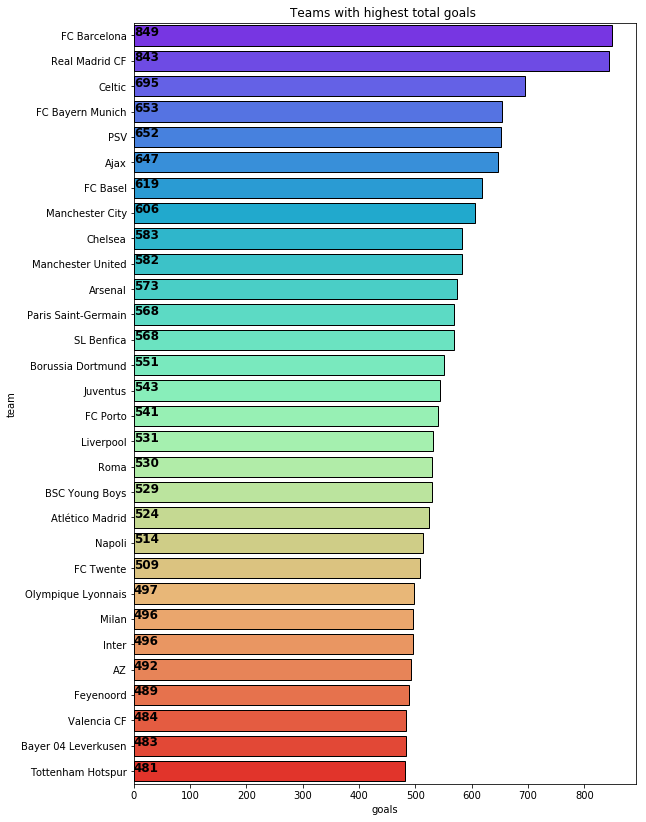

In [59]:
DFs['dfHomeTeam'] = DFs['dfHomeTeam'].rename(columns={'home_team_lname':"team", 'home_team_goal':"goals"})
DFs['dfAwayTeam'] = DFs['dfAwayTeam'].rename(columns={'away_team_lname':"team", 'away_team_goal':"goals"})

DFs['dfGoals'] = pd.concat([DFs['dfHomeTeam'], DFs['dfAwayTeam']])
DFs['dfGoals'] = DFs['dfGoals'].groupby("team")["goals"].sum().reset_index().sort_values(by="goals", ascending= False)

plt.figure(figsize=(9, 14))
ax = sns.barplot(x="goals", y="team", data=DFs['dfGoals'][:30], palette="rainbow", linewidth= 1, edgecolor= "k"*30)

for i,j in enumerate(DFs['dfGoals']["goals"][:30]):
    ax.text(.3, i, j, weight="bold", color = "k", fontsize =12)

plt.title("Teams with highest total goals ")
plt.show()

### Teams Played the Most Matches

In [60]:
dfMatchPlayed_HomeTeam = dfMatchCountryLeague.groupby("home_team_lname")["match_api_id"].count().reset_index()
dfMatchPlayed_HomeTeam = dfMatchPlayed_HomeTeam.rename(columns={"home_team_lname":"team"})

dfMatchPlayed_AwayTeam = dfMatchCountryLeague.groupby("away_team_lname")["match_api_id"].count().reset_index()
dfMatchPlayed_AwayTeam = dfMatchPlayed_AwayTeam.rename(columns={"away_team_lname":"team"})

dfMatchPlayed_Team = pd.concat([dfMatchPlayed_HomeTeam, dfMatchPlayed_AwayTeam], axis=0)

dfMatchPlayed_Team = dfMatchPlayed_Team.groupby("team")["match_api_id"].sum().reset_index().sort_values(
                                                                        by="match_api_id", ascending =False)

dfMatchPlayed_Team = dfMatchPlayed_Team.rename(columns={"match_api_id":"matches_played"})

## print("Number of Matches played: {}".format(dfMatchPlayed_Team["matches_played"].max()) 
## Max number of matches: 304
dfMatchPlayed_Team[ dfMatchPlayed_Team["matches_played"] == dfMatchPlayed_Team["matches_played"].max() ]

team  matches_played
51                   Chelsea             304
22   Athletic Club de Bilbao             304
186      Paris Saint-Germain             304
256               Sunderland             304
180   Olympique de Marseille             304
179       Olympique Lyonnais             304
255               Stoke City             304
83                FC Lorient             304
273              Valencia CF             304
168                Málaga CF             304
167               Motherwell             304
75              FC Barcelona             304
162        Manchester United             304
49                    Celtic             304
161          Manchester City             304
262        Tottenham Hotspur             304
158                Liverpool             304
70                   Everton             304
252         Stade Rennais FC             304
144               Kilmarnock             304
146               LOSC Lille             304
23           Atlético Madrid             304
177                 OGC Nice             304
61             Dundee United             304
202             RCD Espanyol             304
211           Real Madrid CF             304
13                  Aberdeen             304
112                Getafe CF             304
240               Sevilla FC             304
114    Girondins de Bordeaux             304
263              Toulouse FC             304
19                   Arsenal             304
20               Aston Villa             304
11          AS Saint-Étienne             304

### Network Layout For Matches Played among Teams with Top Scores

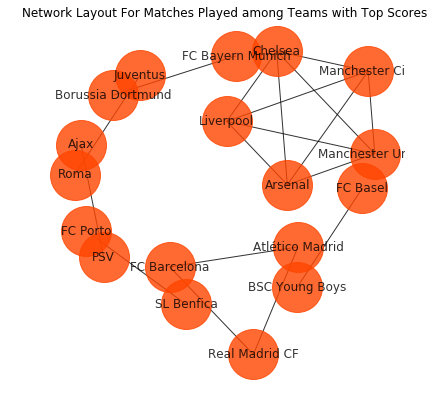

In [61]:
## Selecting Top 50 teams with highest goals

## lstTopScores = list(DFs['dfGoals']["team"][:50])
lstTopScores = list(DFs['dfGoals']["team"][:20])

DFs['dfTopScores'] = dfMatchCountryLeague[["home_team_lname","away_team_lname"]]
DFs['dfTopScores'] = DFs['dfTopScores'][(DFs['dfTopScores']["home_team_lname"].isin(lstTopScores)) &
                                        (DFs['dfTopScores']["away_team_lname"].isin(lstTopScores))]

## import networkx as nx

grf = nx.from_pandas_edgelist(DFs['dfTopScores'], "home_team_lname", "away_team_lname")

fig = plt.figure(figsize=(5, 5))
nx.draw_kamada_kawai(grf, with_labels=True, node_size =2500, node_color ="Orangered", alpha=.8)

plt.title("Network Layout For Matches Played among Teams with Top Scores")
fig.set_facecolor("white")

### Interaction Among Teams
For the sake of completeness I created a network map to depict all matching teams. Although it may not look very useful the mesh map did illustrate the relationships among teams.

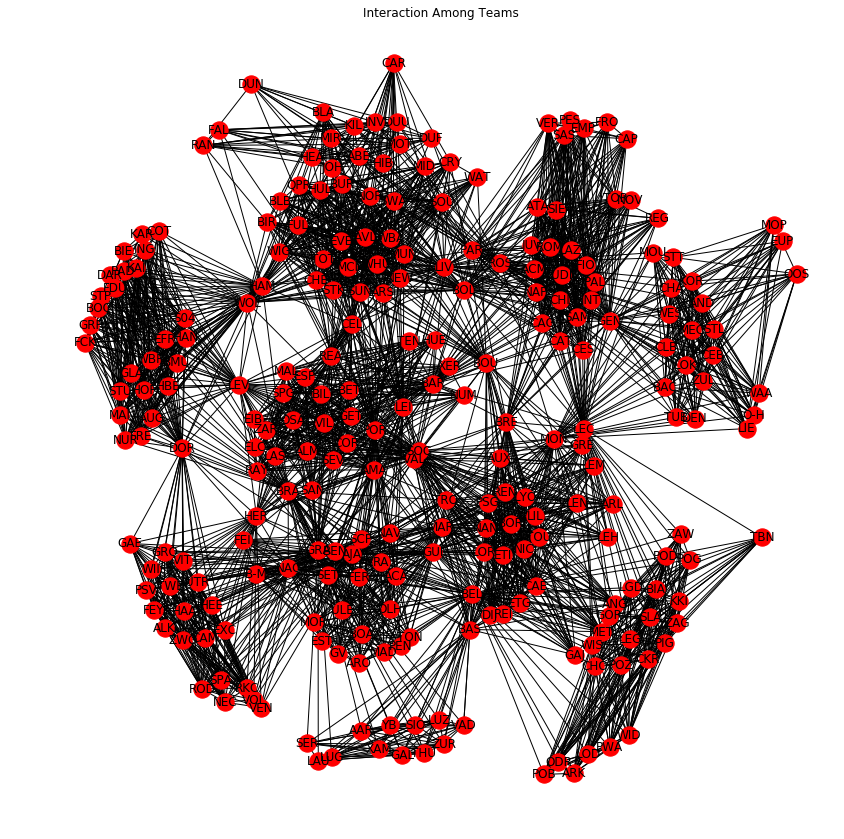

In [62]:
grf = nx.from_pandas_edgelist(dfMatchCountryLeague, "home_team_sname", "away_team_sname")

fig = plt.figure(figsize=(11,11))
nx.draw_kamada_kawai(grf, with_labels = True)
plt.title("Interaction Among Teams")
fig.set_facecolor("white")

### Matches vs Goals By Leagues
This scatter plot shows the number of matches vs. the total goals in all (11) leagues. As expected the total goals are correlated with the number of matches played in leagues. More matches played higher the total goals.  

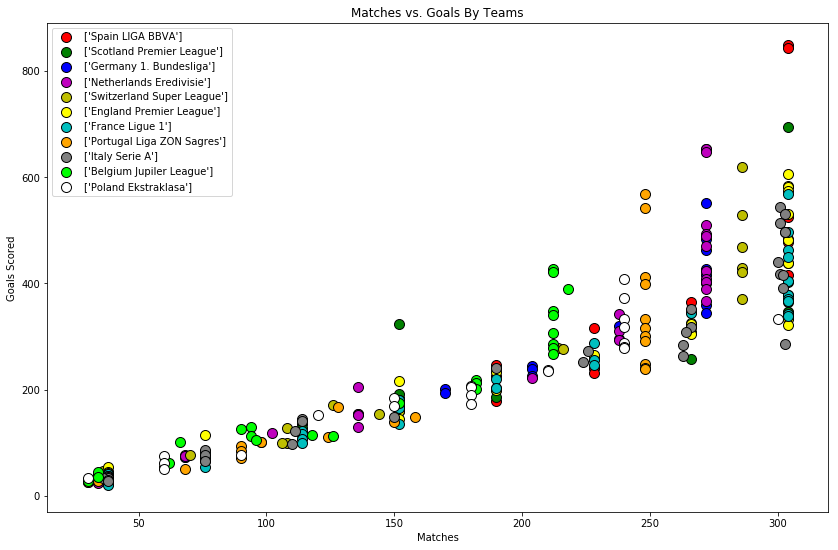

In [63]:
## Use groupby() and agg() to retrieve Goals and Matches to a new dataframe:
DFs['dfMatchesGoals_HomeTeam'] = dfMatchCountryLeague.groupby(
  ["home_team_lname", "league"]).agg({"match_api_id":"count", "home_team_goal":"sum"}).reset_index()

DFs['dfMatchesGoals_AwayTeam'] = dfMatchCountryLeague.groupby(
  ["away_team_lname", "league"]).agg({"match_api_id":"count", "away_team_goal":"sum"}).reset_index()

## Reanme key columns for concatenation: 
DFs['dfMatchesGoals_HomeTeam'] = DFs['dfMatchesGoals_HomeTeam'].rename(columns={'home_team_lname':"team",
                                                                                'match_api_id':"matches",
                                                                                'home_team_goal':"goals"})

DFs['dfMatchesGoals_AwayTeam'] = DFs['dfMatchesGoals_AwayTeam'].rename(columns={'away_team_lname':"team",
                                                                                'match_api_id':"matches",
                                                                                'away_team_goal':"goals"})

## Concatenate both dataframes
DFs['dfMatchesGoals_HomeAwayCombined'] = pd.concat([DFs['dfMatchesGoals_HomeTeam'], DFs['dfMatchesGoals_AwayTeam']])

## Groupby Team and League:
DFs['dfMatchesGoals_HomeAwayCombined'] = DFs['dfMatchesGoals_HomeAwayCombined'].groupby(["team", "league"]
                                                                                       )[["matches", "goals"]
                                                                                        ].sum().reset_index()

## Ranking based on Goals:
DFs['dfMatchesGoals_HomeAwayCombined']= DFs['dfMatchesGoals_HomeAwayCombined'].sort_values(by="goals",ascending=False)

## Visualize result:
plt.figure(figsize=(14, 9))
cplt   = ["r","g","b","m","y","yellow","c","orange","grey","lime","white"]
arrTopScoreLeagues = DFs['dfMatchesGoals_HomeAwayCombined']["league"].unique()  ## numpy.ndarray

for i, j, k in itertools.zip_longest(arrTopScoreLeagues, range(len(arrTopScoreLeagues)), cplt):
  
  plt.scatter("matches", "goals",
              data=DFs['dfMatchesGoals_HomeAwayCombined'][ DFs['dfMatchesGoals_HomeAwayCombined']["league"] == i],
              label=[i], s=100, alpha=1, linewidths=1, edgecolors="k", color=k)
  
  plt.legend(loc="best")
  plt.xlabel("Matches")
  plt.ylabel("Goals Scored")

plt.title("Matches vs. Goals By Teams")
plt.show()

### Matches vs Goals By Top 50 Teams

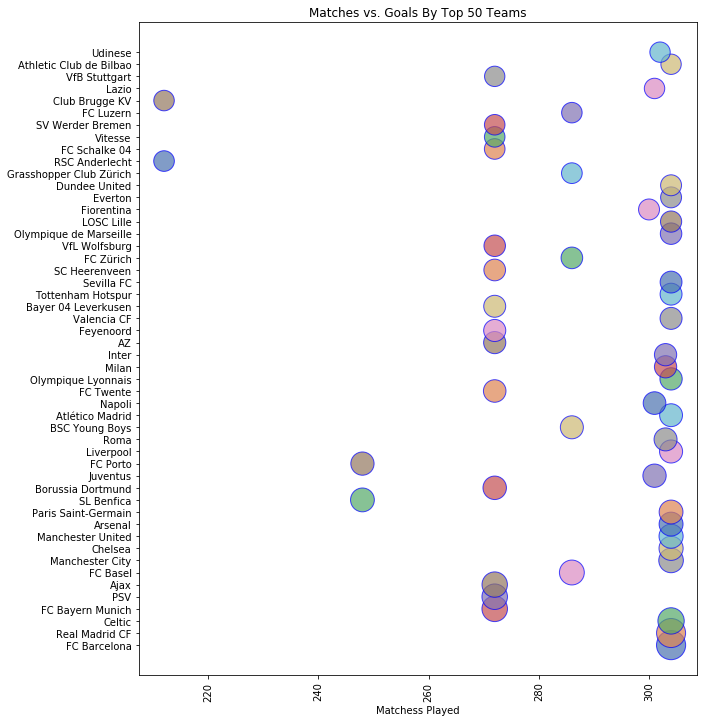

In [64]:
plt.figure(figsize=(10, 12))

cplt = sns.color_palette("deep", 50)

plt.scatter(y = DFs['dfMatchesGoals_HomeAwayCombined']["team"][:50], 
            x = DFs['dfMatchesGoals_HomeAwayCombined']["matches"][:50],
            s = DFs['dfMatchesGoals_HomeAwayCombined']["goals"],
            alpha=.7, c=cplt, linewidths=1, edgecolors="b")

plt.xticks(rotation = 90)
plt.xlabel("Matchess Played")
plt.title("Matches vs. Goals By Top 50 Teams")
plt.show()

### Home Goals Scored By Teams at Home By Season

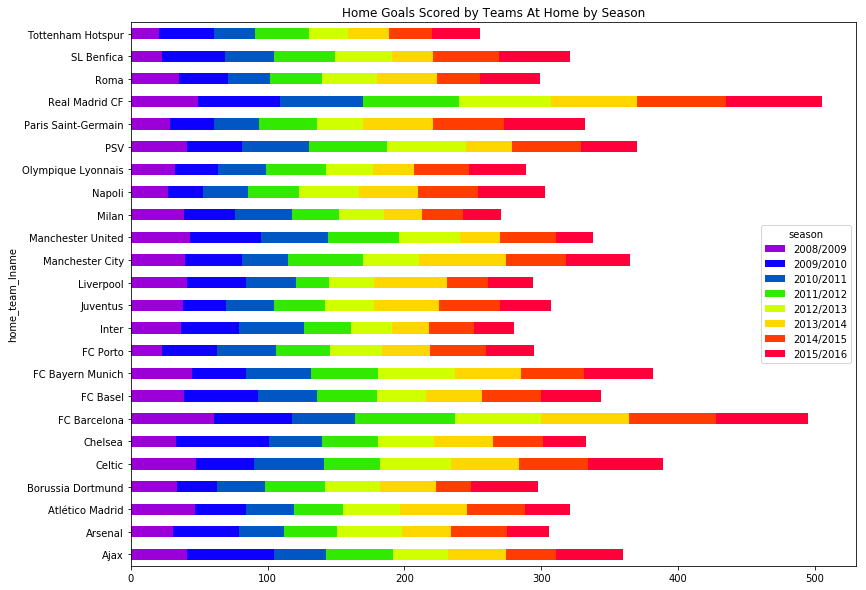

In [65]:
### Home Goals Scored By Teams at Home By Season

wonSeason = dfMatchCountryLeague["Won"].value_counts()[1:25].index

pvHomeGoals = pd.pivot_table(index="home_team_lname", columns="season", values="home_team_goal",
                  data=dfMatchCountryLeague, aggfunc="sum")

pvHomeGoals = pvHomeGoals[pvHomeGoals.index.isin(wonSeason)]

pvHomeGoals.plot(kind="barh", stacked=True, figsize=(13, 10), colors=sns.color_palette("prism",11))
plt.title("Home Goals Scored by Teams At Home by Season")

plt.show()

### Away Goals Scored When Teams Traveled By Season

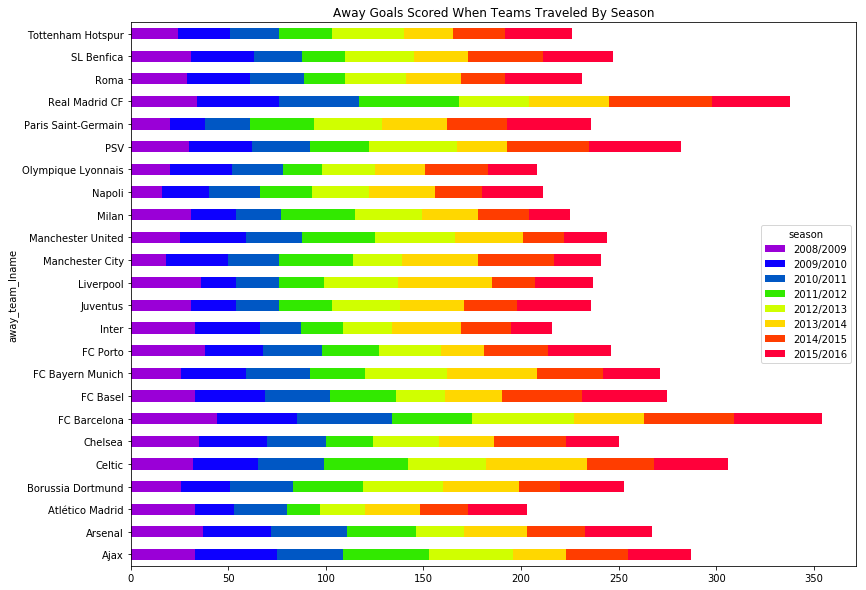

In [66]:
### Away Goals Scored When Teams Traveled By Season
## wonSeason = dfMatchCountryLeague["Won"].value_counts()[1:25].index

pvAwayGoals = pd.pivot_table(index="away_team_lname", columns="season",
                  values="away_team_goal", data=dfMatchCountryLeague, aggfunc="sum")

pvAwayGoals = pvAwayGoals[pvAwayGoals.index.isin(wonSeason)]

pvAwayGoals.plot(kind="barh",stacked=True, figsize=(13,10),colors=sns.color_palette("prism", 11))
plt.title("Away Goals Scored When Teams Traveled By Season")
plt.show()

### Proportion Of Matches Played And Goals Scored In Leagues

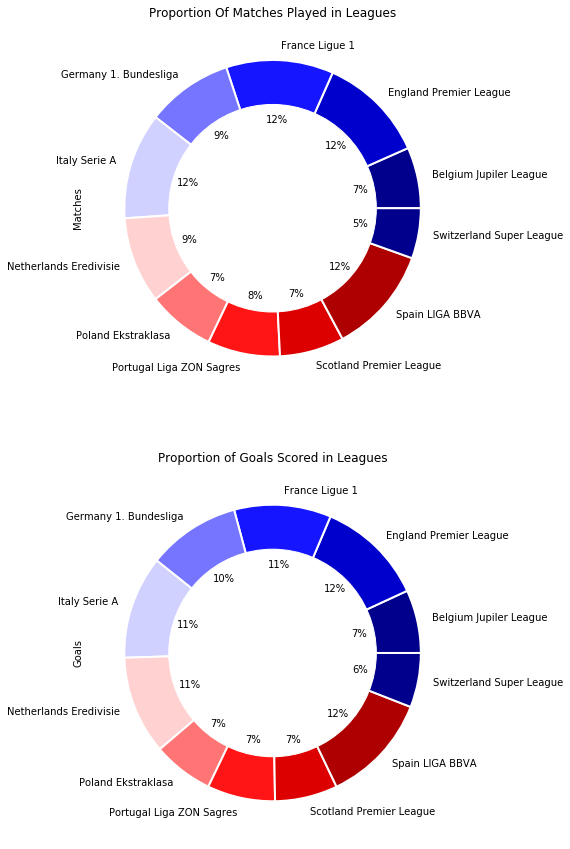

In [67]:
## Derive Total_Goal feature 
dfMatchCountryLeague["total_goal"] = dfMatchCountryLeague["home_team_goal"] + dfMatchCountryLeague["away_team_goal"]

plt.figure(figsize=(7,15))

plt.subplot(211)
agg = dfMatchCountryLeague.groupby(["league"]).agg({"match_api_id":"count", "total_goal":"sum"})

agg["match_api_id"].plot.pie(colors=sns.color_palette("seismic",10), autopct="%1.0f%%",
                             wedgeprops={"linewidth":2, "edgecolor":"white"})

plt.ylabel("Matches")
my_circ = plt.Circle((0,0), .7, color ="white")
plt.gca().add_artist(my_circ)
plt.title("Proportion Of Matches Played in Leagues")


plt.subplot(212)
agg["total_goal"].plot.pie(colors=sns.color_palette("seismic", 10), autopct="%1.0f%%",
                           wedgeprops={"linewidth":2, "edgecolor":"white"})
plt.ylabel("Goals")
my_circ = plt.Circle((0,0), .7, color ="white")
plt.gca().add_artist(my_circ)
plt.title("Proportion of Goals Scored in Leagues")
plt.show()

### Top Winning & Losing Teams

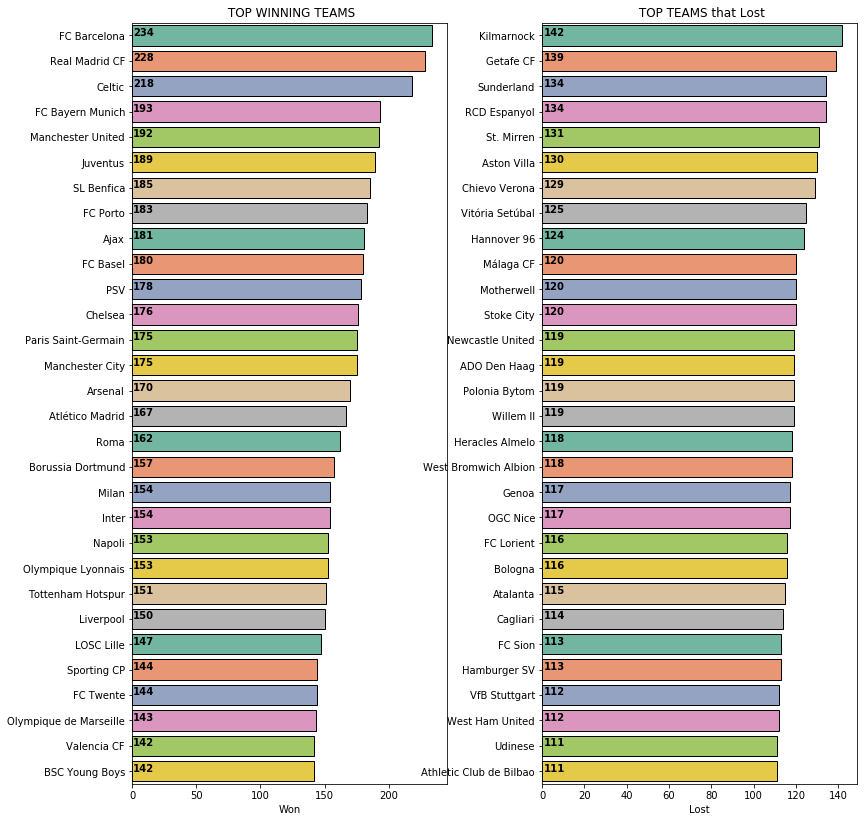

In [68]:
dfWon = dfMatchCountryLeague["Won"].value_counts()[1:].reset_index()
dfLost = dfMatchCountryLeague["Lost"].value_counts()[1:].reset_index()

plt.figure(figsize=(13, 14))

plt.subplot(121)
ax = sns.barplot( dfWon["Won"][:30], dfWon["index"][:30], palette="Set2", linewidth = 1, edgecolor = "k"*30)

plt.title(" TOP WINNING TEAMS")
plt.ylabel("")

for i,j in enumerate(dfWon["Won"][:30]):
  ax.text(.7, i, j, color = "black", weight = "bold")


plt.subplot(122)
ax = sns.barplot(dfLost["Lost"][:30], dfLost["index"][:30], palette="Set2", linewidth = 1, edgecolor = "k"*30)

plt.title(" TOP TEAMS that Lost")
plt.subplots_adjust(wspace = .3)
plt.ylabel("")

for i,j in enumerate(dfLost ["Lost"][:30]):
  ax.text(.7, i, j, color = "black", weight = "bold")

### Performance By Top Teams

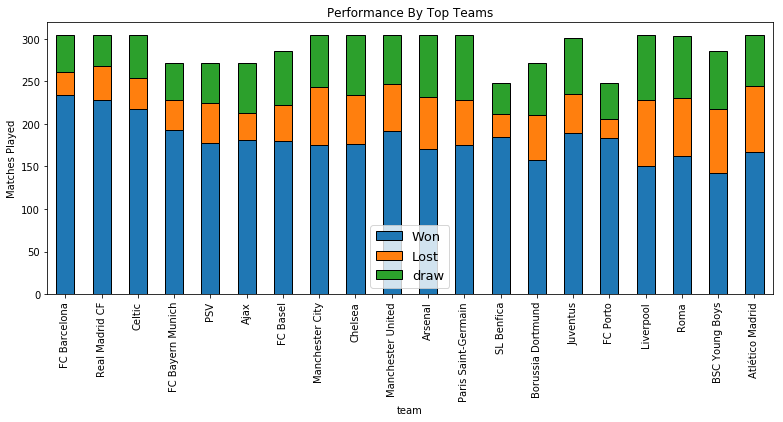

In [69]:
### Merge Won, Draw and Lost data of team to matches played

f = DFs['dfMatchesGoals_HomeAwayCombined'].merge(dfWon, left_on="team", right_on="index", how="left")
f = f.drop("index", axis =1)
f = f.rename(columns={"Outcome":"wins"})

f = f.merge(dfLost, left_on="team", right_on="index", how="left")
f = f.drop("index", axis =1)
dr = dfMatchCountryLeague[ dfMatchCountryLeague["Outcome"] == "DRAW"][["home_team_lname", "away_team_lname"]]

l  = dr["home_team_lname"].value_counts().reset_index()
v  = dr["away_team_lname"].value_counts().reset_index()

l  = l.rename(columns={'index':"team", 'home_team_lname':"draw"})
v  = v.rename(columns={'index':"team", 'away_team_lname':"draw"})

lv = pd.concat([l,v])
lv = lv.groupby("team")["draw"].sum().reset_index()

f = f.merge(lv, left_on="team", right_on="team", how ="left")

## PERFORMANCE BY TOP TEAMS

f = f.sort_values(by="goals",ascending=False)

f_new = f.copy()
f_new.index = f_new.team
f_new[["Won","Lost","draw"]][:20].plot(kind = "bar", figsize=(13,5), stacked =True, linewidth = 1, edgecolor = "k"*20)

plt.legend(loc="best", prop = {"size" : 13})
plt.title("Performance By Top Teams")
plt.ylabel("Matches Played")
plt.show()

### Won vs Lost vs Draw

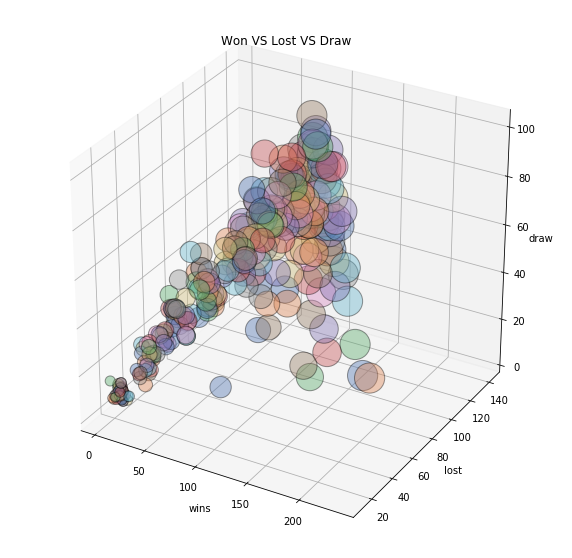

In [70]:
## from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection ="3d")

cplt = sns.color_palette("deep", 296)
ax.scatter(f["Won"], f["Lost"], f["draw"], s=f["matches"]*3, alpha=.4, linewidth =1, edgecolor= "k", c = cplt)
## ax.scatter(f["Won"], f["Lost"], f["draw"], s=f["matches"]*3, alpha=.4, linewidth =1, edgecolor= "k", c = "lime")

ax.set_xlabel("wins")
ax.set_ylabel("lost")
ax.set_zlabel("draw")

plt.title("Won VS Lost VS Draw")
plt.show()

### Area Plot for Match Attributes

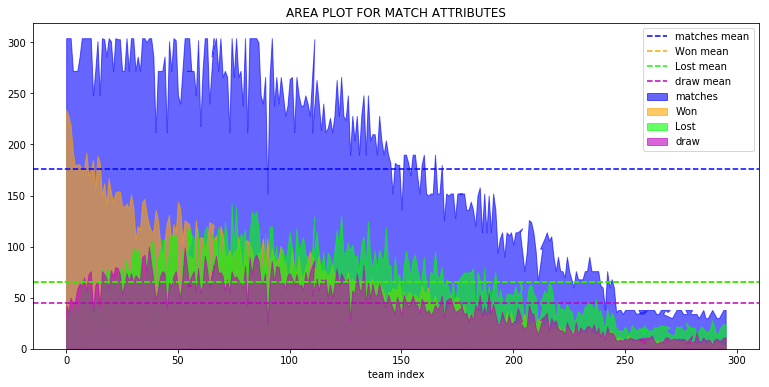

In [71]:
plt.figure(figsize=(13, 6))

cols = ["matches", "Won", "Lost", "draw"]
c    = ["b","orange","lime","m"]
length = len(cols)

for i,j,k in itertools.zip_longest(cols, range(length), c):
  plt.stackplot(f.index,f[i], alpha=.6, color = k, labels=[i])
  plt.axhline(f[i].mean(),color=k, linestyle="dashed", label=i+ " mean")
  plt.legend(loc="best")
  plt.title("AREA PLOT FOR MATCH ATTRIBUTES")
  plt.xlabel("team index")

### Number of Matches Played In Each League vs. Total Goals Scored

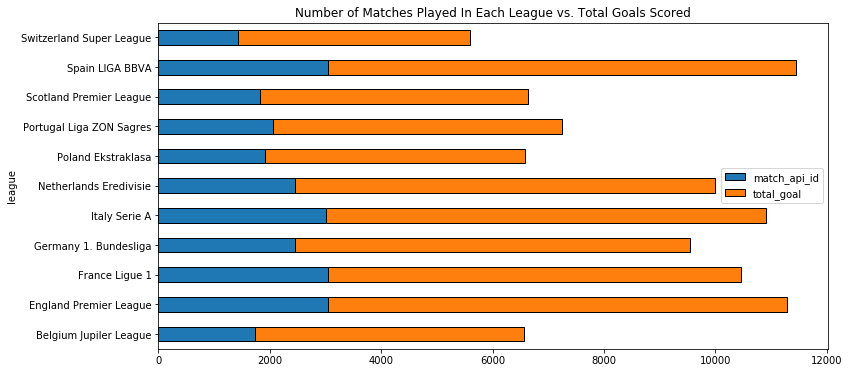

In [72]:
dfMatchCountryLeague.groupby(
  ["league"]).agg({"match_api_id":"count", "total_goal":"sum"}).plot(
  kind="barh", stacked =True, figsize=(12, 6), linewidth = 1, edgecolor = "k"*dfMatchCountryLeague["league"].nunique())

plt.title("Number of Matches Played In Each League vs. Total Goals Scored")
plt.show()

### Word Cloud of More-Than-100-Win Teams
Again, use a Word Cloud to visualize the frequency of words, in this case winning teams, which won more than 100 games between 2008 and 2015. I saw FC Barcelona, Real Madrid FC and Celtic stood out from the cloud.

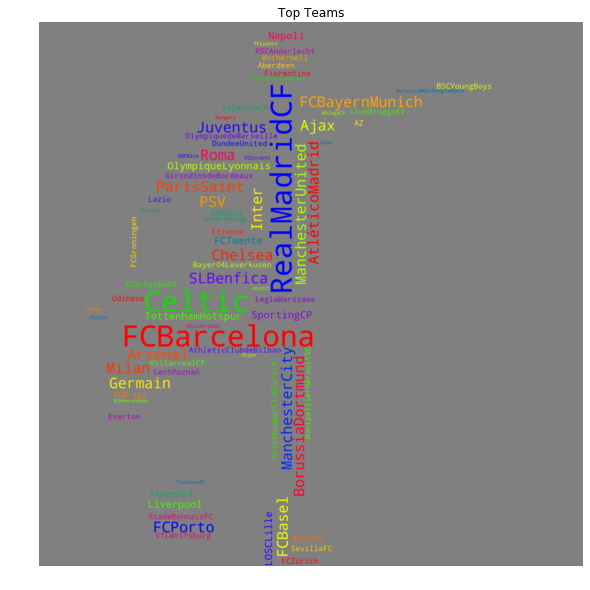

In [73]:
## from wordcloud import WordCloud
## import nltk

wrd = dfMatchCountryLeague[dfMatchCountryLeague["Won"] != "DRAW"]["Won"].to_frame()
wrd = wrd["Won"].value_counts()[wrd["Won"].value_counts() > 100].keys().str.replace(" ","")
wrd = pd.DataFrame(wrd)

img = np.array(Image.open("input/picture-wrd/zSoccer_LcdozeKqi.jpg"))

wc = WordCloud(background_color="gray", scale=2, mask=img, colormap="prism").generate(str(wrd[0]))

plt.figure(figsize=(13, 10))
plt.imshow(wc, interpolation="bilinear")

plt.axis("off")
plt.title("Top Teams")
plt.show()

### Goals Scored in each Season of Leagues

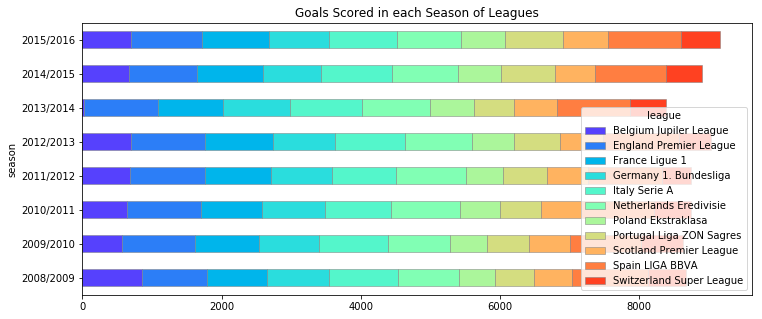

In [74]:
pvt = pd.pivot_table(index="season", columns="league", values="total_goal", data=dfMatchCountryLeague, aggfunc="sum")

pvt.plot(kind = "barh", stacked = True, figsize =(12, 5),
         colors =sns.color_palette("rainbow",11),
         linewidth = .5,edgecolor = ["grey"]*10)

plt.title("Goals Scored in each Season of Leagues")
plt.show()

###  Matches Played Among Top Teams

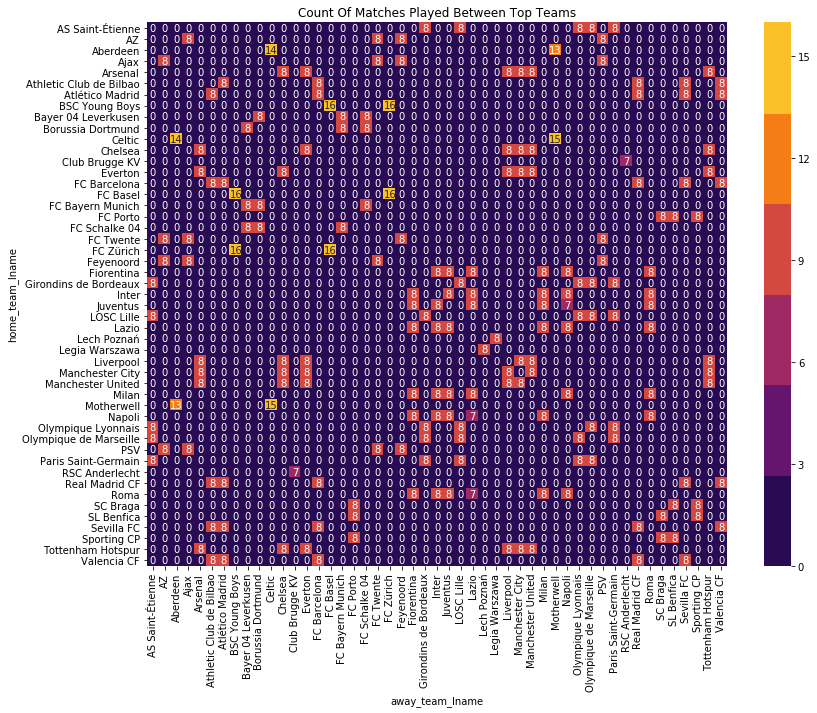

In [75]:
wonSeason50 = dfMatchCountryLeague["Won"].value_counts()[1:50].index

wonTeams = dfMatchCountryLeague[(dfMatchCountryLeague["home_team_lname"].isin(wonSeason50)) &
                                (dfMatchCountryLeague["away_team_lname"].isin(wonSeason50))]

ctwonTeams = pd.crosstab(wonTeams["home_team_lname"], wonTeams["away_team_lname"])

plt.figure(figsize=(13,10))
sns.heatmap(ctwonTeams, annot=True, cmap=sns.color_palette("inferno"))
plt.title("Count Of Matches Played Between Top Teams")
plt.show()

### Championship Teams in the Past Eight Seasons By Leagues
This section illustrates the championship teams of each league in the past eight seasons. This dataset covers one league from each country so we have only 11 leagues. 

I created a function to draw barplots, one for each league.
> **Note**: Since the argument in matplotlib subplot() requires a 3-dight integer we need to use the comma format, i.e. (row, col, order), on this argument when the number of plots goes beyond 10 

Next, I leveraged violin plots to view the median and probability density of total goals scored in each league.

At the end, we made a graphic illustration of a rank of the top teams across all leagues based on the number of championships they won in their leagues.

Selected European Football Leagues:

Belgium Jupiler League;
England Premier League;
France Ligue 1;
Germany 1. Bundesliga;
Italy Serie A;
Netherlands Eredivisie;
Poland Ekstraklasa;
Portugal Liga ZON Sagres;
Scotland Premier League;
Spain LIGA BBVA;
Switzerland Super League


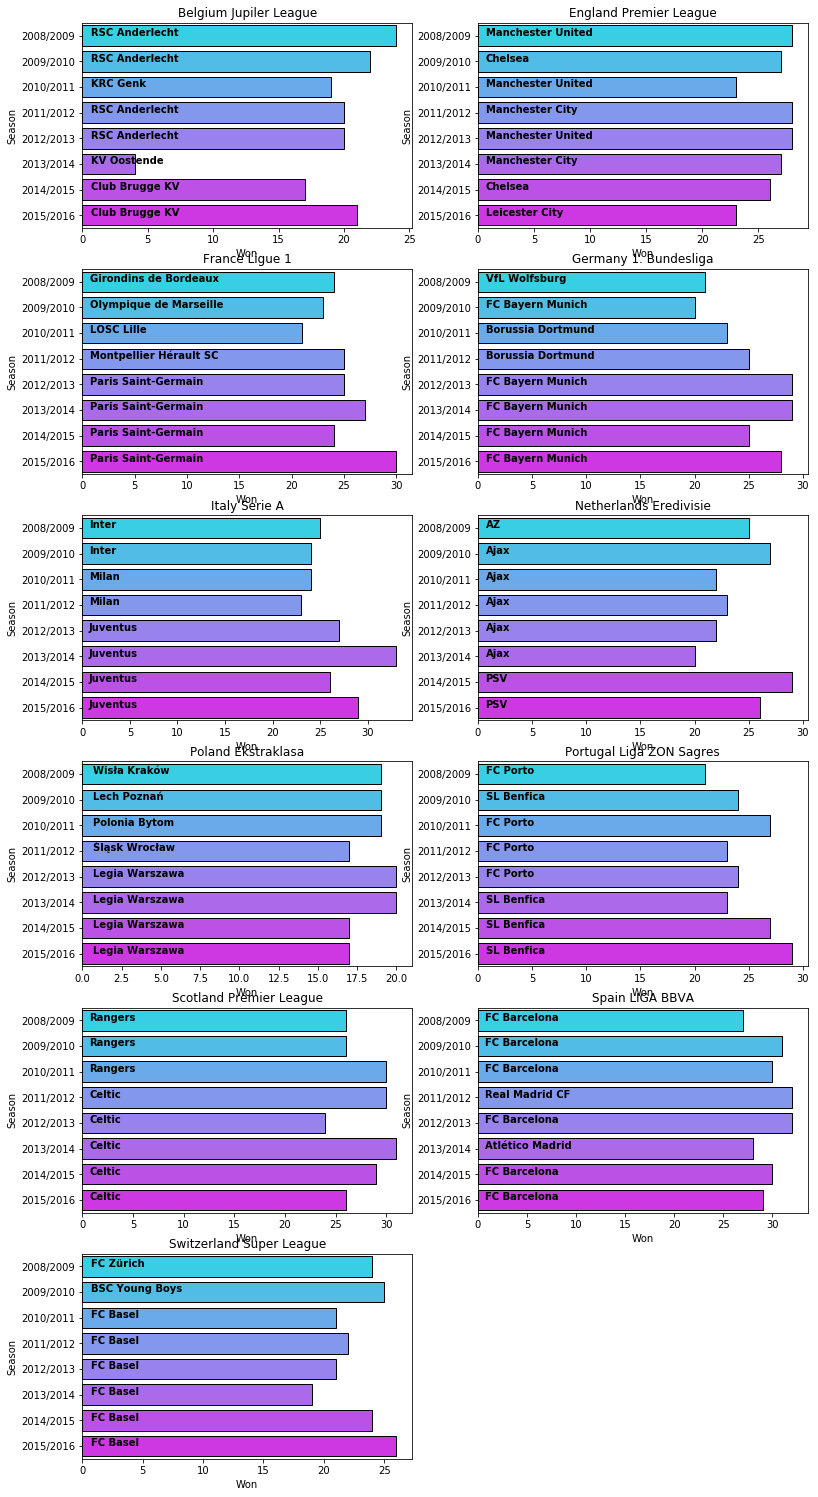

In [76]:
## Print League Names 
Leagues = getMbrNames(DFs['dfLeague'])
print("Selected European Football Leagues:\n\n{}".format(";\n".join(Leagues)))

dfWonSeasonLeague = dfMatchCountryLeague[["season", "league", "Won"]]
dfWonSeasonLeague["team"] = dfWonSeasonLeague["Won"]
dfWonSeasonLeague = dfWonSeasonLeague.groupby(
  ["season","league","team"])["Won"].count().reset_index().sort_values(by=["season","league","Won"], ascending=False)

dfWonSeasonLeague = dfWonSeasonLeague[dfWonSeasonLeague["team"] != "DRAW"]

dfWonSeasonLeague = dfWonSeasonLeague.drop_duplicates(subset=["season", "league"],
                                                      keep="first").sort_values(by=["league","season"],ascending=True)

leagues = [lg for lg in DFs['dfLeague']['name']]  ## 11 is over 9. subplot() can't seem to handle.

plt.figure(figsize=(13, 40))

def draw_Barplot_WonSeasonLeague(league, *pos):
  
  row, col, order = pos
  plt.subplot(row, col, order)

  lg = dfWonSeasonLeague[dfWonSeasonLeague["league"] == league]
  ax = sns.barplot(lg["Won"], lg["season"], palette="cool",
                  linewidth = 1, edgecolor = "k"*lg["season"].nunique())  

  for i,j in enumerate(lg["team"]):
      ax.text(.7, i, j, weight = "bold")

  plt.title(league)
  plt.xlabel("Won")
  plt.ylabel("Season")
  
row, col, init = 9, 2, 1
pos = [row, col, init]

for league in leagues:  
  draw_Barplot_WonSeasonLeague(league, *pos)
  pos[2] += 1

plt.show()

### Violin Plot for Total Goals Scored By Leagues
Similar to a box plot, a Violin plot can tell us the median and interquartile range of a numerical feature in a data set. In addition, it also shows the probability density of the data at different values which are usually smoothed by a kernel density estimator.

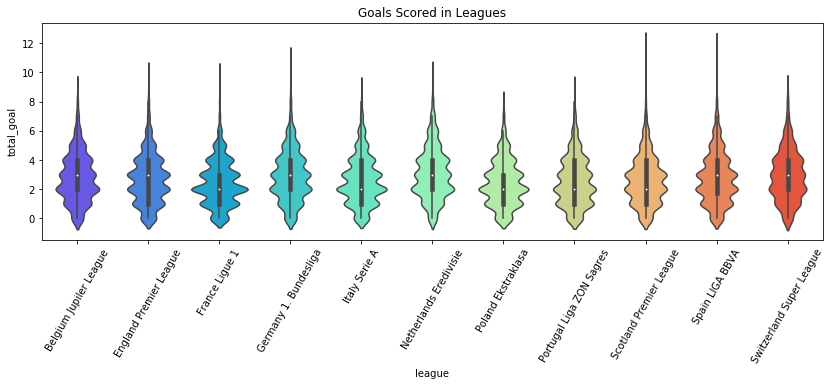

In [77]:
plt.figure(figsize=(14, 4))

sns.violinplot(dfMatchCountryLeague["league"], dfMatchCountryLeague["total_goal"], palette="rainbow")
plt.title("Goals Scored in Leagues")
plt.xticks(rotation = 60)
plt.show()

### Top Teams By Leagues
The following barchart visualized the teams which won the most championships in history in their leagues. 

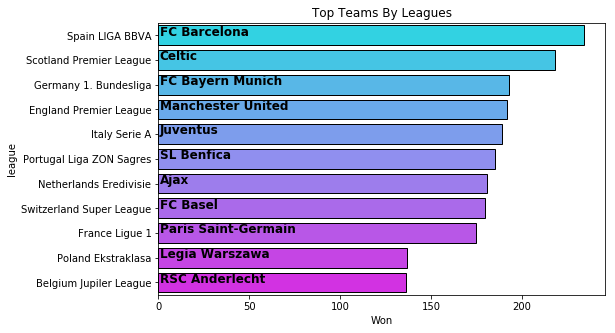

In [78]:

x = pd.DataFrame(dfMatchCountryLeague.groupby(["league", "Won"])["Won"].count())
## print(x.columns)  ## Index(['Won'], dtype='object')

x = x.rename(columns={"Won":"team"}).reset_index()
## print(x.columns)  ## Index(['league', 'Won', 'team'], dtype='object')

x = x.rename(columns={"Won":"team", "team":"Won"})
## print(x.columns)  ## Index(['league', 'team', 'Won'], dtype='object')

x = x.sort_values(by="Won",ascending=False)

x = x[x["team"] != "DRAW"]
x = x.drop_duplicates(subset=["league"], keep="first")

plt.figure(figsize=(8, 5))
ax =sns.barplot(x["Won"],x["league"], palette="cool", linewidth = 1, edgecolor = "k"*10)

for i,j in enumerate(x["team"]):
  ax.text(.7,i,j,weight = "bold",fontsize = 12)

plt.title("Top Teams By Leagues")
plt.show()

### Rank the Best Championship Teams Across All Leagues
This diagram gives us an idea which teams won the most championships in their leagues and also rank these top teams based on the number they achieved. Although the levels of championship competition were different among the leagues the rank still identified the teams with the most glory in history in their leagues. This rank can serve as a stepping stone for next research to find out which team is the best of the best in history.   

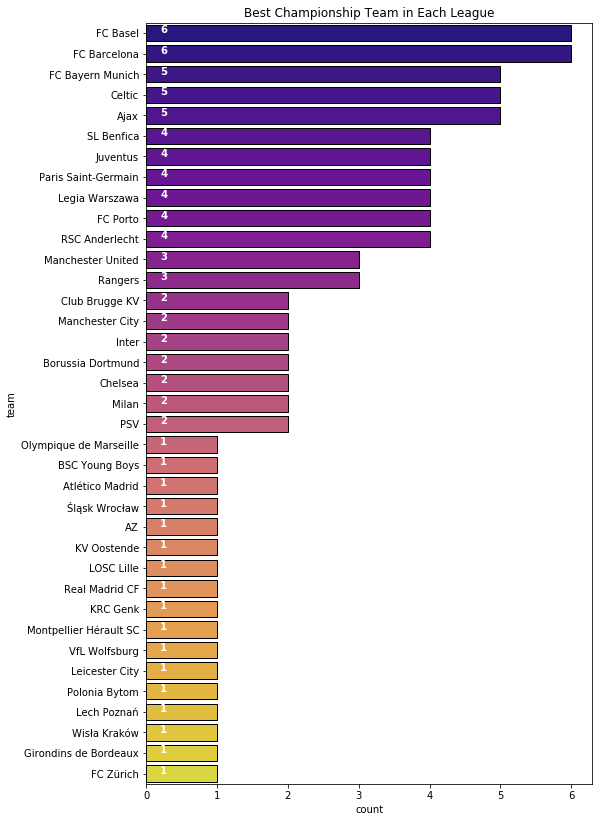

In [79]:
plt.figure(figsize=(8, 14))

ax = sns.countplot(y=dfWonSeasonLeague["team"], order=dfWonSeasonLeague["team"].value_counts().index,
                   palette="plasma", linewidth = 1, edgecolor = "k" * dfWonSeasonLeague["team"].nunique())

plt.title("Best Championship Team in Each League")

for i,j in enumerate(dfWonSeasonLeague["team"].value_counts().values):
  ax.text(.2, i, j, color = "white", weight="bold")

## <a id='conclusions'></a> Conclusions

Like baseball and basketball, Soccer is a team sport. Both players and teams are the center of focus when it comes to evaluation and prediction. Matches and leagues are built around them, followed by countries and others. 

Analyzing the league, country, player, player attributes, team and team atributes tables gave a better understanding of the data. Once the respective features are joined and merged with the match table, machine learning algorithms can be used to predict the winner of the future soccer matches in the european league. This kernel also allows for the opportunity to practice using the seaborn library and visualizing the data.

Domain knowledge is essential in data analysis. In this case deep understanding of the meaning of each attributes can certainly helps on these decision:
- Choose relavent categories when making radar charts,
- Recognize key attributes to evaluate players,
- select criteria to identify so-called top rated players, etc.

Fortunately, search engines are our friends. Blogs, news, tutorials can be good resouces and are only a few keystrokes away to build required knowledge.  

In this project I created graphic illustration to answer questions. I created Team Comparator and Player Comparator. Some of the questions are listed as follows,

- **Does Player's "Overall Rating" depend on any Player Attribute(s)?**
- **What are the similarities and differences in terms of skills among Top Overall_Rating Players?**
- **Create a Word Cloud for players with Overall Rating beyond 88**
- **Does the proportion of preferred foot change between all players and top players with overall rating higher than 80?**, etc.

I think the work I built in this project can serve as a good fundation for further analyses.

### Lock database by closing Cursor and DB Connection:

In [80]:
## Lock database by closing Cursor and DB Connection:
cursor.close()
conn.close()

In [81]:
# from subprocess import call
# call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset_completed.ipynb'])

## <a id='references'></a> References

* [Analyzing Soccer Data by JohnErome-Utunedi](https://www.kaggle.com/efezinoerome/analyzing-soccer-data)
* [European Football Data Analysis by Pavan Raj - Geographic](https://www.kaggle.com/pavanraj159/european-football-data-analysis)
* [Data Analysis using SQL by Dima Rudov](https://www.kaggle.com/dimarudov/data-analysis-using-sql)
* [Working with SQLite Databases using Python and Pandas](https://www.dataquest.io/blog/python-pandas-databases/)
* [Printing a database summary](http://sebastianraschka.com/Articles/2014_sqlite_in_python_tutorial.html#printing-a-database-summary)
* [How to make more than 10 subplots in a figure](https://stackoverflow.com/questions/37424530/how-to-make-more-than-10-subplots-in-a-figure/37444059)
* [More than 9 subplots in matplotlib](https://stackoverflow.com/questions/4158367/more-than-9-subplots-in-matplotlib)